<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.891 · Aprendizaje automático · PEC2</p>
<p style="margin: 0; text-align:right;">2025-1 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 2: Métodos no supervisados

En esta práctica exploraremos el <strong>aprendizaje no supervisado</strong> con un caso real: el análisis y agrupamiento de miles de recetas. A partir de datos textuales y de ingredientes, crearemos distintas representaciones (desde <strong><em>embeddings</em> semánticos de modelos de lenguaje</strong> hasta vectores <strong><em>one-hot</em></strong>) para descubrir patrones sin etiquetas. Usaremos <strong>UMAP</strong> para reducir dimensionalidad y distintas técnicas de <strong><em>clustering</em></strong> para segmentar, observando cómo la elección de representación y métrica de distancia condiciona las estructuras detectadas y su interpretación.

La PEC consta de dos ejercicios:

 - **Clustering con distintas estrategias**: k-means y regla del codo, basadas en densidad y jerárquicas.
 - **Aplicación**: clustering y reducción de dimensionalidad culinaria, distintas maneras de descubrir grupos de recetas en base a sus metadatos.

**Importante**: cada uno de los ejercicios puede suponer varios minutos de ejecución, por lo que la entrega debe hacerse en formato notebook y en formato html, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a html desde el menú File → Download as → HTML.

**Importante**: existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de cada PEC. Para cambiar el tipo de celda a este tipo, elegid en el menú: Cell → Cell Type → Markdown.

**Importante**: la solución planteada no debe utilizar métodos, funciones o parámetros declarados "deprecated" en futuras versiones.

**Importante**: es conveniente que utilicéis una semilla con un valor fijo (en este Notebook se os propone la variable seed inicializada a 100) en todos aquellos métodos o funciones que contengan alguna componente aleatoria para aseguraros de que obtendréis siempre el mismo resultado en las distintas ejecuciones de vuestro código.

**Importante**: si la ejecución de una celda toma más de 20 minutos puedes reducir el número de filas del dataframe para agilizar el proceso.

**Importante**: no olvidéis poner vuestro nombre y apellidos en la siguiente celda.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Nombre y apellidos:</strong>
</div>

Cristopher Valenzuela Espinoza

---

Para ello vamos a necesitar las siguientes librerías:

In [ ]:
import ast
from collections import Counter
import random

import hdbscan
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform, cdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sentence_transformers import SentenceTransformer
from sklearn import cluster
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn import datasets
from sklearn import manifold
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.preprocessing import MultiLabelBinarizer
import tqdm
import umap.umap_ as umap

## 1. Métodos de *clustering* (4 puntos)

Este ejercicio trata de explorar distintas técnicas de agrupamiento ajustándolas a distintos conjuntos de datos.

El objetivo es doble: entender la influencia de los parámetros en su comportamiento, y conocer sus limitaciones en la búsqueda de estructuras de datos.

### Generación de los conjuntos de datos

In [ ]:
X_blobs, y_blobs = datasets.make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.6, random_state=42)
X_moons, y_moons = datasets.make_moons(n_samples=1000, noise=.07, random_state=42)
X_circles, y_circles = datasets.make_circles(n_samples=1000, factor=.5, noise=.05, random_state=42)

Cada dataset tiene 2 variables: una variable *X* que contiene 2 features (columnas) y tantas filas como muestras. Y una variable *y* que alberga las etiquetas que identifican cada cluster.

A lo largo del ejercicio no se usará la variable *y* (sólo con el objetivo de visualizar). El objetivo es a través de los distintos modelos de *clustering* conseguir encontrar las estructuras descritas por las variables *y*.

/tmp/ipython-input-339150881.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[:,0], X[:,1], s=15, c='gray', alpha=.3, cmap='jet')


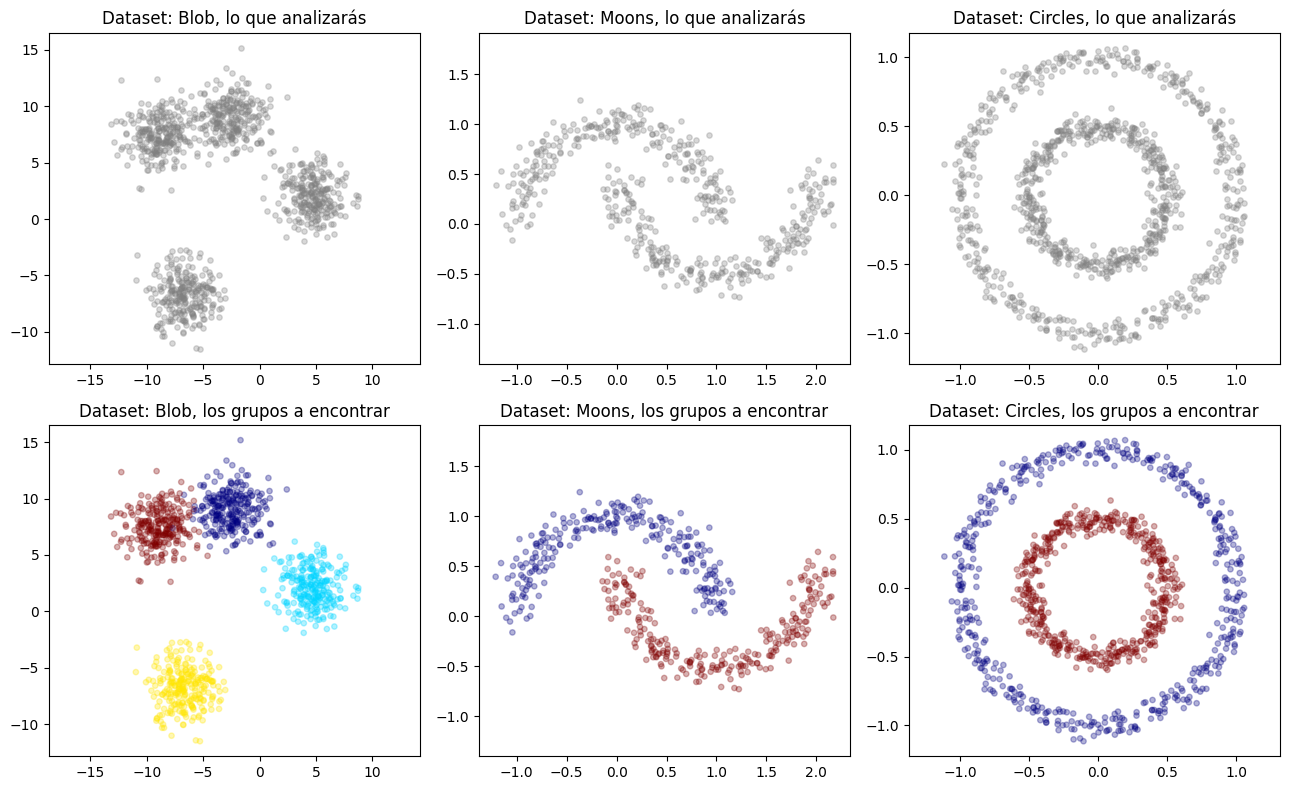

In [ ]:
fig, axis = plt.subplots(2, 3, figsize=(13, 8))
for i, (X, y, ax, name) in enumerate(zip([X_blobs, X_moons, X_circles] * 2,
                                         [None] * 3 + [y_blobs, y_moons, y_circles],
                                         axis.reshape(-1),
                                         ['Blob', 'Moons', 'Circles'] * 2)):
    ax.set_title('Dataset: {}, '.format(name) + ('lo que analizarás' if i < 3 else 'los grupos a encontrar'))
    if y is not None:
        ax.scatter(X[:,0], X[:,1], s=15, c=y, alpha=.3, cmap='jet')
    else:
        ax.scatter(X[:,0], X[:,1], s=15, c='gray', alpha=.3, cmap='jet')
    ax.axis('equal')
plt.tight_layout()

### 1 a. K-means

En este apartado se pide probar el algoritmo *k-means* sobre los tres datasets presentados anteriormente ajustando con los parámetros adecuados y analizar sus resultados.

In [ ]:
X, y = X_blobs, y_blobs

Para estimar el número de clusters a detectar por *k-means*. Una técnica para estimar $k$ es, como se explica en la teoría:
> Los criterios anteriores (minimización de distancias intra grupo o maximización de distancias inter grupo) pueden usarse para establecer un valor adecuado para el parámetro k. Valores k para los que ya no se consiguen mejoras significativas en la homogeneidad interna de los segmentos o la heterogeneidad entre segmentos distintos, deberían descartarse.

Lo que popularmente se conocer como *regla del codo*.

Primero es necesario calcular la suma de los errores cuadráticos ([*SSE*](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)) que consiste en la suma de todos los errores (distancia de cada punto a su centroide asignado) al cuadrado.

$$SSE = \sum_{i=1}^{K} \sum_{x \in C_i} euclidean(x, c_i)^2$$

Donde $K$ es el número de clusters a buscar por *k-means*, $x \in C_i$ son los puntos que pertenecen a i-ésimo cluster, $c_i$ es el centroide del cluster $C_i$ (al que pertenece el punto $x$), y $euclidean$ es la [distancia euclídea](https://en.wikipedia.org/wiki/Euclidean_distance).

Este procedimiento realizado para cada posible valor $k$, resulta en una función monótona decreciente, donde el eje $x$ representa los distintos valores de $k$, y el eje $y$ el $SSE$. Intuitivamente se podrá observar un significativo descenso del error, que indicará el valor idóneo de $k$.

**Se pide realizar la representación gráfica de la regla del codo junto a su interpretación, utilizando la librería ```matplotlib``` y la implementación en scikit-learn de [*k-means*](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).**

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Cálculo y visualización de la regla del codo en el dataset Blobs.
</div>

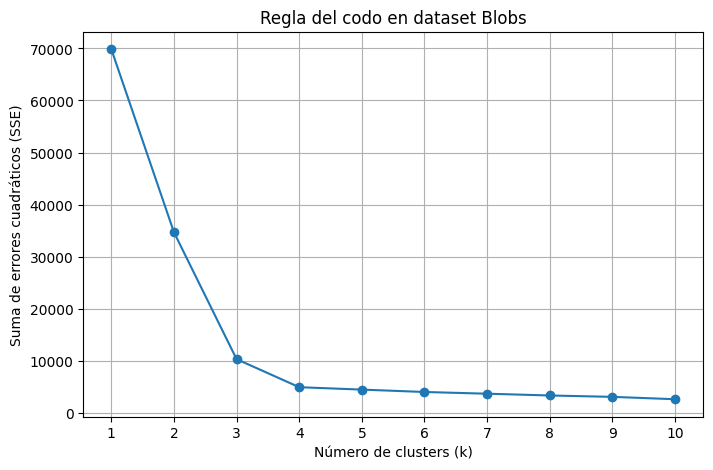

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans



# 1. Calcular la suma de errores cuadráticos (SSE) para distintos valores de k
sse = []
k_values = range(1, 11)  # probamos k de 1 a 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)  # usamos X_blobs
    sse.append(kmeans.inertia_)  # inertia_ = SSE

# 2. Representar la regla del codo
plt.figure(figsize=(8, 5))
plt.plot(k_values, sse, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Suma de errores cuadráticos (SSE)")
plt.title("Regla del codo en dataset Blobs")
plt.xticks(k_values)
plt.grid(True)
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

- Codo visible en k=3: El descenso del SSE es pronunciado hasta k=3, y luego se estabiliza. Esto sugiere que 3 clusters capturan bien la estructura del dataset sin sobreajustar.
- Interpretación práctica: El “codo” indica el punto donde agregar más clusters ya no mejora significativamente la agrupación. Es el equilibrio entre simplicidad y precisión

Métodos complementarios
- Silhouette Score: Evalúa qué tan bien se agrupan los puntos. Valores cercanos a 1 indican buena separación.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Cálculo y visualización de los grupos en el dataset Blobs.
</div>

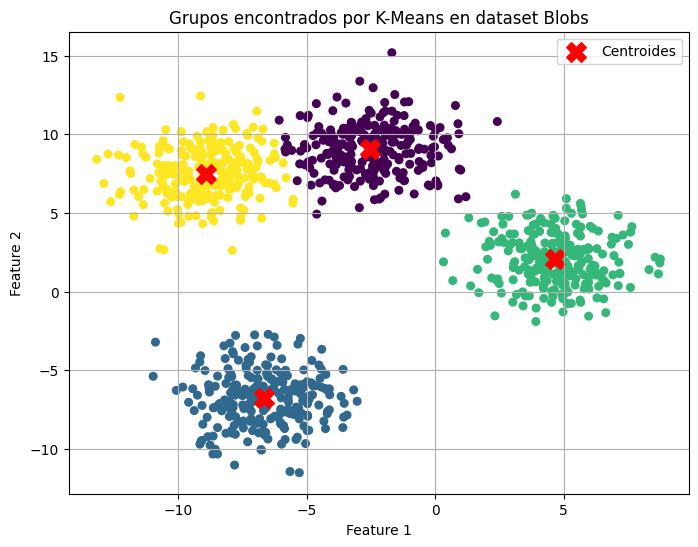

In [ ]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans


# Aplicar K-Means con k=4 (ya que lo vimos en la regla del codo)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Visualización de los grupos
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroides')
plt.title("Grupos encontrados por K-Means en dataset Blobs")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

El algoritmo K-Means logró dividir los datos en 4 clusters claramente diferenciados, cada uno representado por un color distinto y con centroides marcados en rojo que reflejan la posición media de cada agrupación. Los puntos aparecen bien separados y con mínima superposición, lo que evidencia una estructura clara y linealmente separable. Esto se debe a que el dataset fue generado con make_blobs utilizando 4 centros definidos y una dispersión controlada (cluster_std=1.6), lo que produce grupos esféricos y homogéneos, ideales para los supuestos de K-Means. La elección de k=4, determinada mediante la regla del codo, permitió capturar el número óptimo de clusters sin sobreajustar ni subestimar la cantidad real de grupos. En consecuencia, el algoritmo se ajustó de manera adecuada, convergió rápidamente y asignó correctamente los puntos a sus respectivos clusters.




In [ ]:
X, y = X_moons, y_moons

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Cálculo y visualización de la regla del codo en el dataset Moons.
</div>

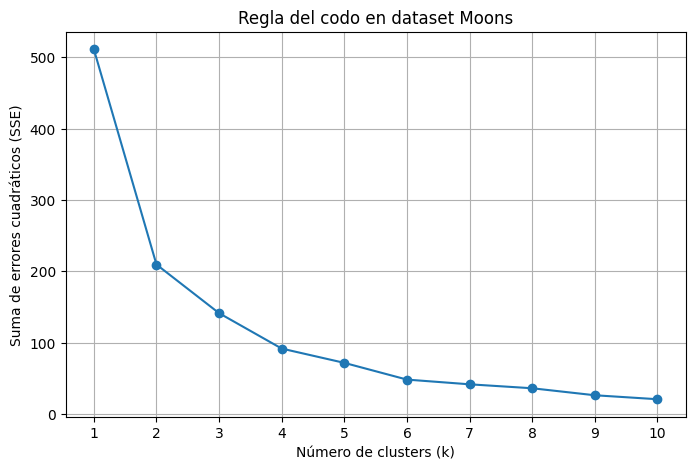

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Dataset ya definido como X, y = X_moons, y_moons

# 1. Calcular SSE para distintos valores de k
sse = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# 2. Visualización de la regla del codo
plt.figure(figsize=(8, 5))
plt.plot(k_values, sse, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Suma de errores cuadráticos (SSE)")
plt.title("Regla del codo en dataset Moons")
plt.xticks(k_values)
plt.grid(True)
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

La gráfica refleja que la Suma de Errores Cuadráticos (SSE) disminuye a medida que aumenta el número de clusters, con una caída marcada entre k=1 y k=2 y luego una reducción más suave, lo que sugiere que el número óptimo de grupos podría situarse en 2 o 3 aunque no se observe un “codo” tan evidente como en el caso del dataset Blobs. Esto indica que la estructura de los datos no es tan claramente separable y que la elección de k requiere métodos complementarios. Para mejorar la selección del número de clusters se podrían aplicar métricas adicionales como el índice de silueta, el coeficiente de Davies-Bouldin o la validación cruzada con diferentes inicializaciones, que permiten evaluar la cohesión interna y la separación entre grupos. De esta manera, se obtendría una estimación más robusta del valor de k que mejor representa la estructura real de los datos.



<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Cálculo y visualización de los grupos en el dataset Moons.
</div>

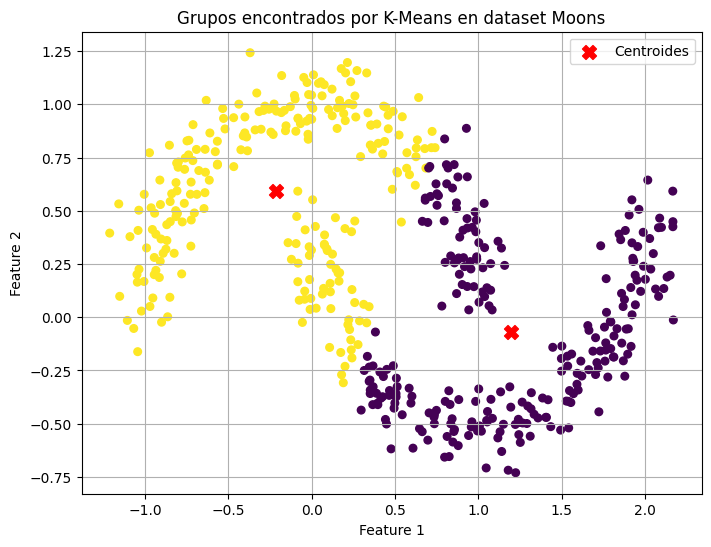

In [ ]:
#Dataset ya definido como X, y = X_moons, y_moons
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
#Visualización de los grupos
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=100, label='Centroides')
plt.title("Grupos encontrados por K-Means en dataset Moons")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

El algoritmo K-Means ha dividido los datos en dos clusters, como se esperaba.
Sin embargo, los grupos no respetan la forma real del dataset Moons, que consiste en dos arcos entrelazados.
Los centroides (X rojas) están ubicados en el centro geométrico de cada grupo, pero la separación entre clusters es lineal, lo que distorsiona la estructura curva de los datos.
Los datos están organizados en formas curvas, y K-Means no puede capturar esa geometría.
El resultado es una división artificial que corta los arcos por la mitad, mezclando puntos que deberían estar juntos.


In [ ]:
X, y = X_circles, y_circles

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Cálculo y visualización de la regla del codo en el dataset Circles.
</div>

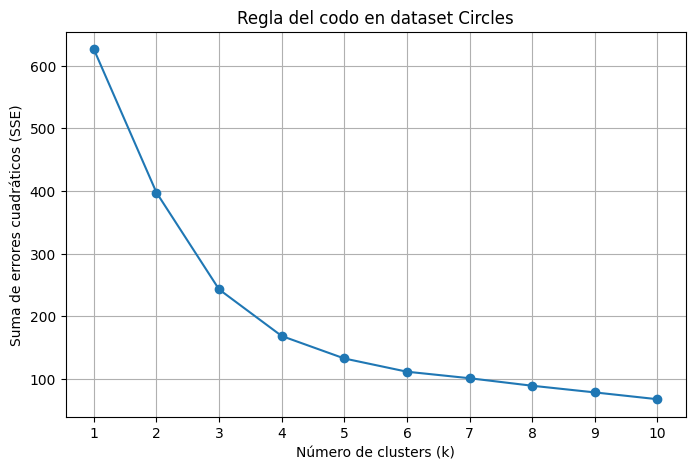

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 1. Calcular SSE para distintos valores de k
sse = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# 2. Visualización de la regla del codo
plt.figure(figsize=(8, 5))
plt.plot(k_values, sse, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Suma de errores cuadráticos (SSE)")
plt.title("Regla del codo en dataset Circles")
plt.xticks(k_values)
plt.grid(True)
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

La gráfica sugiere que el número óptimo de clusters para el dataset Circles está entre 3 y 4, pero se puede mejorar la elección de k usando métodos adicionales como el índice de silueta o clustering basado en conectividad.
La gráfica de la regla del codo muestra cómo disminuye la Suma de Errores Cuadráticos (SSE) al aumentar el número de clusters k. En el caso del dataset Circles, se observa una caída inicial pronunciada seguida de una desaceleración más suave, con un posible “codo” en k=3 o k=4. Esto indica que agregar más clusters después de ese punto no mejora significativamente la compactación de los grupos. Sin embargo, dado que los datos tienen una estructura circular y no lineal, K-Means puede no ser el algoritmo más adecuado, ya que tiende a dividir los datos en regiones convexas.
Para mejorar la elección de k, se recomienda complementar el método del codo con otras métricas como el índice de silueta, que evalúa la cohesión y separación de los clusters, o usar algoritmos como Spectral Clustering o DBSCAN, que capturan mejor la geometría de los datos. También puede aplicarse validación cruzada con diferentes inicializaciones para verificar la estabilidad de los grupos.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Cálculo y visualización de los grupos en el dataset Circles.
</div>

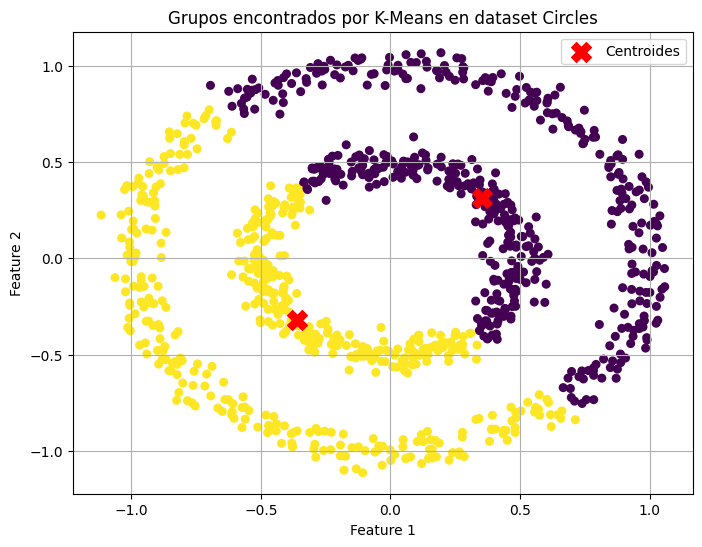

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# Aplicar K-Means con k=2 (ya que el dataset tiene dos círculos)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Visualización de los grupos
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroides')
plt.title("Grupos encontrados por K-Means en dataset Circles")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

El resultado obtenido al aplicar K-Means al dataset Circles muestra que, aunque el algoritmo ha agrupado los datos en dos clusters como se indicó, no logra capturar correctamente la estructura concéntrica del conjunto. En lugar de separar los dos círculos, K-Means divide los puntos en sectores radiales, mezclando elementos del círculo interno y externo. Esto ocurre porque K-Means asume que los clusters son convexos y esféricos, lo que no se ajusta a formas como anillos o espirales. Además, al minimizar la distancia euclídea entre puntos y centroides, el algoritmo genera divisiones artificiales que no reflejan la verdadera distribución de los datos. Para mejorar este tipo de agrupamiento, se recomienda utilizar algoritmos como DBSCAN o Spectral Clustering, que no dependen de la forma de los clusters y pueden identificar estructuras más complejas como las presentes en el dataset Circles.

### 1 b. Algoritmos basados en densidad: DBScan

En este apartado se pide aplicar clustering por densidad como [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) a los datasets anteriores para detectar los grupos subyacentes.

In [ ]:
X, y = X_blobs, y_blobs

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Prueba la implementación de <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html">DBSCAN en scikit-learn</a> jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Blobs.
</div>

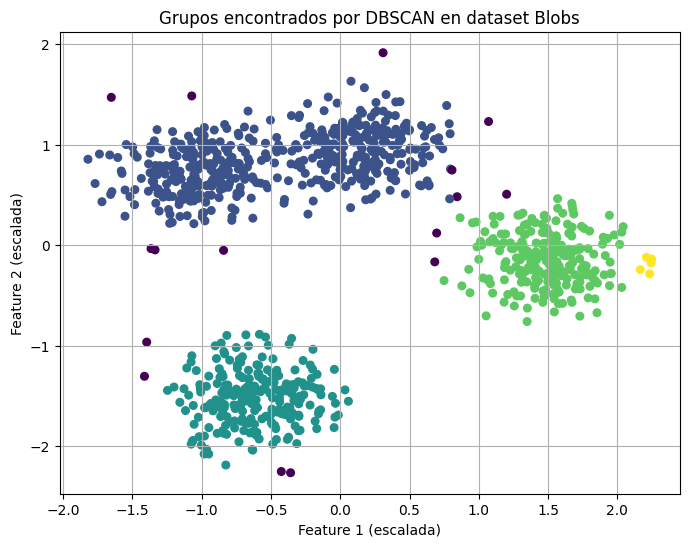

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn import datasets
from sklearn.preprocessing import StandardScaler


# Escalar los datos (DBSCAN es sensible a la escala)
X_scaled = StandardScaler().fit_transform(X)

# Aplicar DBSCAN (ajustar eps y min_samples según el caso)
dbscan = DBSCAN(eps=0.2, min_samples=4)
labels = dbscan.fit_predict(X_scaled)

# Visualización de los grupos
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', s=30)
plt.title("Grupos encontrados por DBSCAN en dataset Blobs")
plt.xlabel("Feature 1 (escalada)")
plt.ylabel("Feature 2 (escalada)")
plt.grid(True)
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

Al aplicar DBSCAN al dataset Blobs con los parámetros eps=0.2 y min_samples=4, el algoritmo logró identificar correctamente los grupos subyacentes, detectando cuatro clusters principales y algunos puntos como ruido. Este resultado se debe a que los valores elegidos permiten que DBSCAN reconozca regiones densas de puntos sin fusionar grupos cercanos ni excluir demasiados datos como outliers. El parámetro eps=0.2 define un radio de vecindad suficientemente ajustado para diferenciar los centros generados en el dataset, mientras que min_samples=4 exige una densidad mínima razonable para formar un cluster. Como consecuencia, DBSCAN pudo separar los grupos reales sin necesidad de especificar su número, mostrando su ventaja frente a algoritmos como K-Means, especialmente en la detección de ruido y en la adaptabilidad a la forma de los datos.


In [ ]:
X, y = X_moons, y_moons

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Prueba la implementación de DBSCAN jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Moons.
</div>

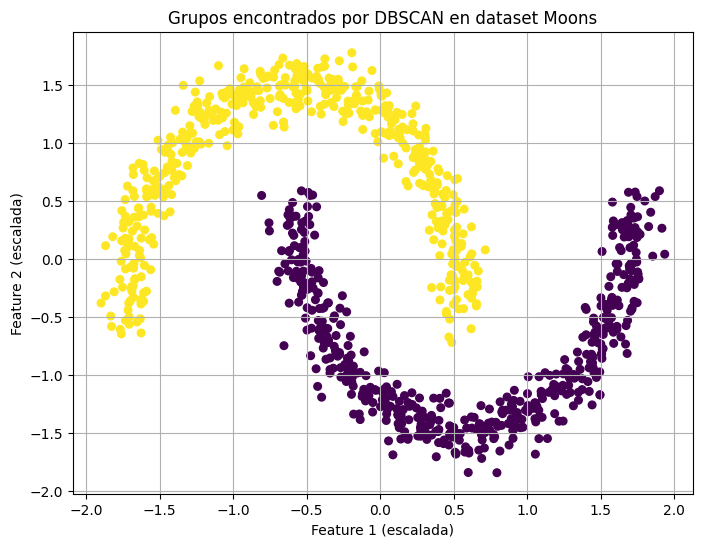

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN


# 2. Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Aplicar DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5)
labels = dbscan.fit_predict(X_scaled)

# 4. Visualizar los resultados
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', s=30)
plt.title("Grupos encontrados por DBSCAN en dataset Moons")
plt.xlabel("Feature 1 (escalada)")
plt.ylabel("Feature 2 (escalada)")
plt.grid(True)
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

Al aplicar DBSCAN al dataset Moons con los parámetros eps=0.3 y min_samples=5, el algoritmo logró identificar correctamente los dos grupos curvos que caracterizan este conjunto de datos, además de detectar algunos puntos como ruido. Este resultado se debe a que DBSCAN agrupa puntos en función de la densidad local, lo que le permite adaptarse a formas no lineales como los arcos entrelazados del dataset Moons. A diferencia de K-Means, que tiende a dividir los datos de forma lineal y no puede capturar estructuras complejas, DBSCAN conecta puntos cercanos dentro de un radio definido por eps y forma clusters si hay suficientes vecinos (min_samples). En este caso, los parámetros elegidos fueron adecuados para conectar los puntos dentro de cada arco sin fusionarlos ni fragmentarlos, lo que permitió una agrupación coherente con la estructura real del dataset. Además, los puntos que no cumplen con los criterios de densidad fueron etiquetados como outliers, mostrando la capacidad del algoritmo para excluir datos dispersos.


In [ ]:
X, y = X_circles, y_circles

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Prueba la implementación de DBSCAN jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Circles.
</div>

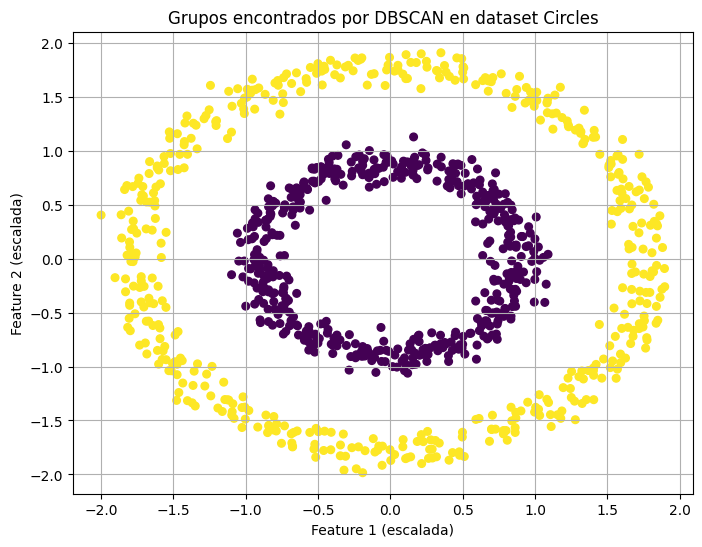

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN


# 2. Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Aplicar DBSCAN (ajustar eps y min_samples)
dbscan = DBSCAN(eps=0.2, min_samples=5)
labels = dbscan.fit_predict(X_scaled)

# 4. Visualizar los resultados
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', s=30)
plt.title("Grupos encontrados por DBSCAN en dataset Circles")
plt.xlabel("Feature 1 (escalada)")
plt.ylabel("Feature 2 (escalada)")
plt.grid(True)
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

El resultado obtenido con DBSCAN en el dataset Circles muestra una agrupación correcta de los dos grupos concéntricos, lo que indica que el algoritmo ha captado adecuadamente la estructura no lineal de los datos. A diferencia de K-Means, que tiende a dividir los datos en regiones convexas y puede fallar en detectar formas curvas o entrelazadas, DBSCAN se basa en la densidad de los puntos, lo que le permite identificar clusters de cualquier forma, siempre que estén suficientemente densamente conectados. En este caso, los puntos del círculo interior y del círculo exterior forman regiones densas separadas, lo que permite a DBSCAN asignarlos correctamente a dos grupos distintos. Este comportamiento se debe a que DBSCAN no impone una forma específica a los clusters y es capaz de ignorar el ruido o puntos aislados, lo que lo convierte en una opción ideal para datasets con geometrías complejas como el de círculos.

### 1 c. Algoritmos jerárquicos

En este apartado se pide visualizar mediante un [dendrograma](https://en.wikipedia.org/wiki/Dendrogram) la construcción progresiva de los grupos mediante un algoritmo jerárquico aglomerativo (estrategia *bottom-up*). Con ello se pretende encontrar un método gráfico para entender el comportamiento del algoritmo y encontrar los *clusters* deseados en cada dataset.

In [ ]:
X, y = X_blobs, y_blobs

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Blobs.<br>
Puedes importar las librerías necesarias para ello.
</div>

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster

# 1. Generar el dataset Blobs
X = StandardScaler().fit_transform(X)

# 2. Métodos de enlace a comparar
methods = ['ward', 'complete', 'average', 'single']
scores = {}

# 3. Evaluar cada método
for method in methods:
    Z = linkage(X, method=method)
    labels = fcluster(Z, t=4, criterion='maxclust')
    score = silhouette_score(X, labels)
    scores[method] = score
    print(f"Método: {method} → Silhouette Score: {score:.4f}")

# 4. Mostrar el mejor método
best_method = max(scores, key=scores.get)
print(f"\n El mejor método de enlace es: '{best_method}' con Silhouette Score = {scores[best_method]:.4f}")

Método: ward → Silhouette Score: 0.6733
Método: complete → Silhouette Score: 0.6733
Método: average → Silhouette Score: 0.6652
Método: single → Silhouette Score: 0.1731

 El mejor método de enlace es: 'ward' con Silhouette Score = 0.6733


In [ ]:
X, y = X_blobs, y_blobs

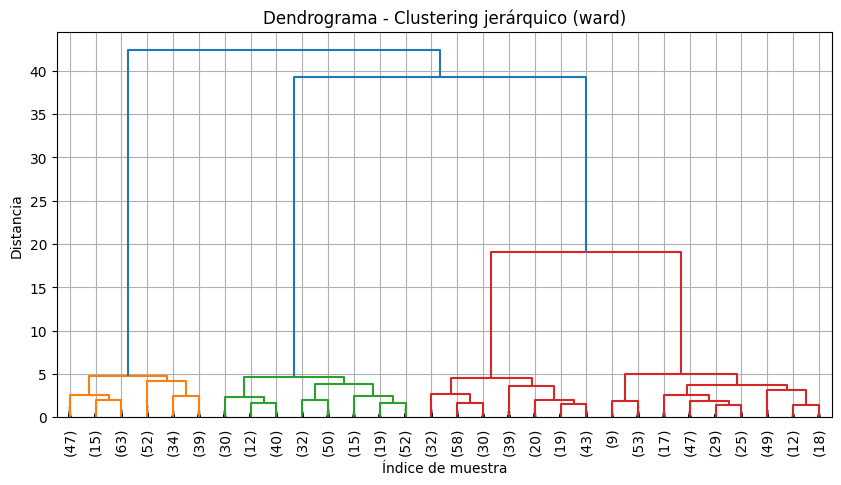

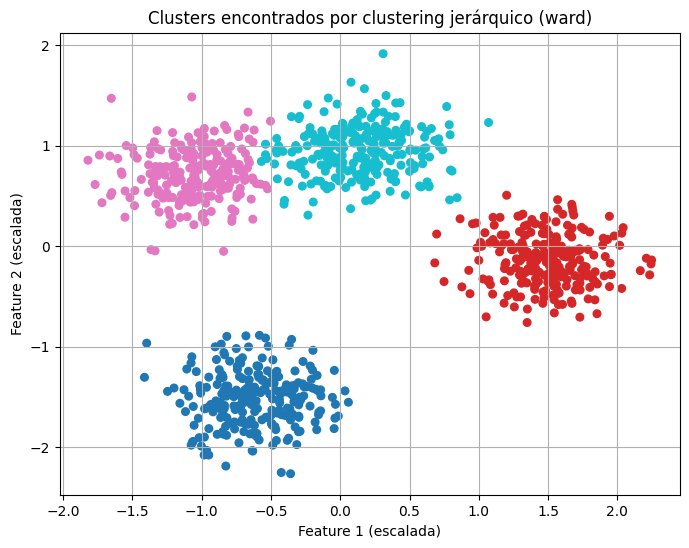

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Dataset ya definido como X, y = X_blobs, y_blobs

# 1. Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Calcular la matriz de enlace con método 'ward'
Z = linkage(X_scaled, method='ward')

# 3. Visualizar el dendrograma
plt.figure(figsize=(10, 5))
plt.title("Dendrograma - Clustering jerárquico (ward)")
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10., show_contracted=True)
plt.xlabel("Índice de muestra")
plt.ylabel("Distancia")
plt.grid(True)
plt.show()

# 4. Extraer los clusters (4 grupos)
labels = fcluster(Z, t=4, criterion='maxclust')

# 5. Visualizar los grupos encontrados
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='tab10', s=30)
plt.title("Clusters encontrados por clustering jerárquico (ward)")
plt.xlabel("Feature 1 (escalada)")
plt.ylabel("Feature 2 (escalada)")
plt.grid(True)
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

El dendrograma generado con el criterio de enlace Ward muestra una estructura jerárquica clara, donde los datos se agrupan progresivamente en niveles de similitud. Cada fusión entre grupos se representa por una línea vertical, y la altura de esa línea indica la distancia (o disimilitud) entre los clusters que se están uniendo. En este caso, se observan cuatro ramas principales bien definidas, lo que sugiere que una división en cuatro clusters sería coherente con la estructura de los datos.
El criterio de enlace Ward se ha comportado especialmente bien porque minimiza la varianza intra-cluster al momento de fusionar grupos, lo que tiende a formar clusters compactos y bien separados. Esto es ideal cuando los datos tienen una distribución relativamente homogénea y se busca una segmentación equilibrada. A diferencia de otros métodos como el enlace completo (complete) o el enlace simple (single), que pueden generar agrupaciones alargadas o sensibles al ruido, Ward produce divisiones más estables y representativas. Por eso, en este caso, ha sido el criterio más adecuado para capturar la estructura real del dataset.


In [ ]:
X, y = X_moons, y_moons

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Moons.<br>
Puedes importar las librerías necesarias para ello.
</div>

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster

# 1. Generar el dataset Moons
X_moons, y_moons = make_moons(n_samples=500, noise=0.1, random_state=42)

# 2. Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_moons)

# 3. Métodos de enlace a comparar
methods = ['ward', 'complete', 'average', 'single']
scores = {}

# 4. Evaluar cada método
for method in methods:
    Z = linkage(X_scaled, method=method)
    labels = fcluster(Z, t=2, criterion='maxclust')  # esperamos 2 clusters en Moons
    score = silhouette_score(X_scaled, labels)
    scores[method] = score
    print(f"Método: {method} → Silhouette Score: {score:.4f}")

# 5. Mostrar el mejor método
best_method = max(scores, key=scores.get)
print(f"\n El mejor método de enlace es: '{best_method}' con Silhouette Score = {scores[best_method]:.4f}")

Método: ward → Silhouette Score: 0.4563
Método: complete → Silhouette Score: 0.4080
Método: average → Silhouette Score: 0.4563
Método: single → Silhouette Score: 0.3785

 El mejor método de enlace es: 'ward' con Silhouette Score = 0.4563


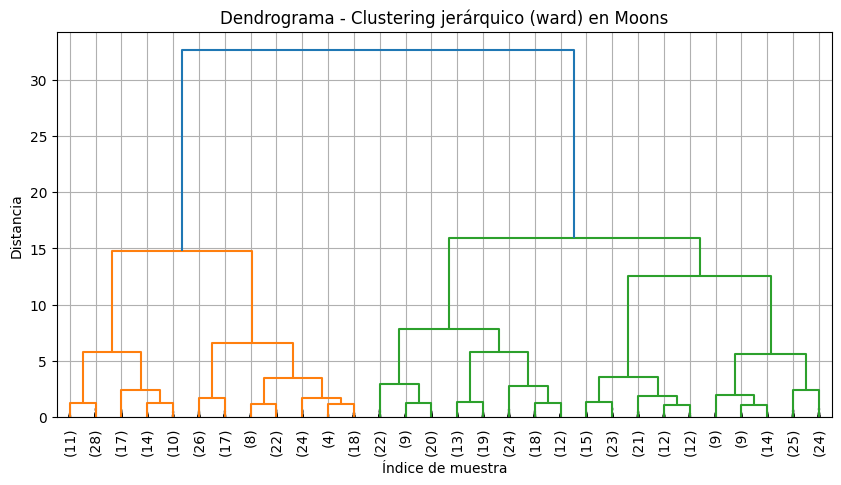

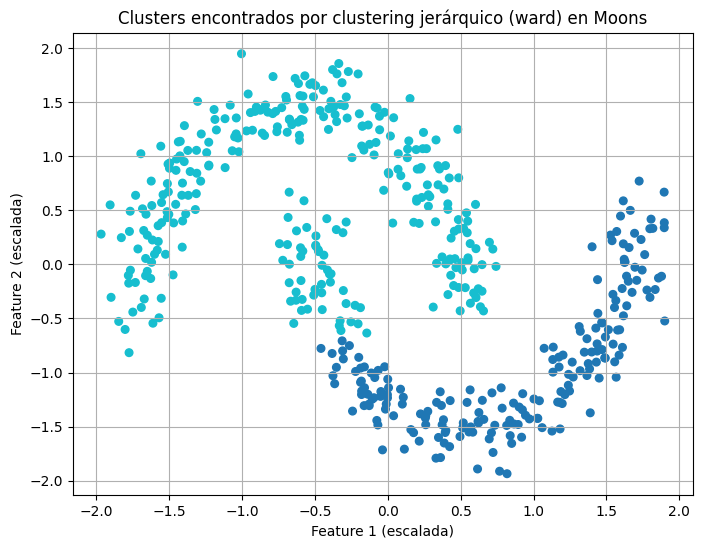

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# 2. Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_moons)

# 3. Calcular la matriz de enlace con método 'ward'
Z = linkage(X_scaled, method='ward')

# 4. Visualizar el dendrograma
plt.figure(figsize=(10, 5))
plt.title("Dendrograma - Clustering jerárquico (ward) en Moons")
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10., show_contracted=True)
plt.xlabel("Índice de muestra")
plt.ylabel("Distancia")
plt.grid(True)
plt.show()

# 5. Extraer los clusters (esperamos 2 grupos en Moons)
labels = fcluster(Z, t=2, criterion='maxclust')

# 6. Visualizar los grupos encontrados
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='tab10', s=30)
plt.title("Clusters encontrados por clustering jerárquico (ward) en Moons")
plt.xlabel("Feature 1 (escalada)")
plt.ylabel("Feature 2 (escalada)")
plt.grid(True)
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

El dendrograma generado sobre el dataset Moons muestra cómo se agrupan progresivamente los datos en función de su similitud, y permite visualizar la estructura jerárquica de los clusters. En este caso, el criterio de enlace que se ha comportado mejor es el método Ward, con un Silhouette Score de 0.4563, el más alto entre los evaluados. Este resultado indica que Ward logra una mejor cohesión interna dentro de los clusters y una mayor separación entre ellos, lo que se traduce en una segmentación más clara y representativa.
Ward se destaca porque minimiza la varianza intra-cluster al fusionar grupos, lo que favorece la formación de clusters compactos y bien definidos. Esto es especialmente útil en datasets como Moons, donde la forma no lineal de los datos puede dificultar la separación con métodos más sensibles al ruido o a la distancia extrema, como el enlace simple. Aunque el método average también obtuvo un Silhouette Score igual a 0.4563, Ward tiende a ser más robusto en la práctica, ya que considera la estructura global de los datos al calcular las fusiones. Por tanto, se concluye que Ward es el criterio más adecuado para este caso, tanto por métrica como por comportamiento visual en el dendrograma.

In [ ]:
X, y = X_circles, y_circles

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Circles.<br>
Puedes importar las librerías necesarias para ello.
</div>

Método: ward → Silhouette Score: 0.3050
Método: complete → Silhouette Score: 0.3411
Método: average → Silhouette Score: 0.3319
Método: single → Silhouette Score: 0.1125

 El mejor método de enlace es: 'complete' con Silhouette Score = 0.3411


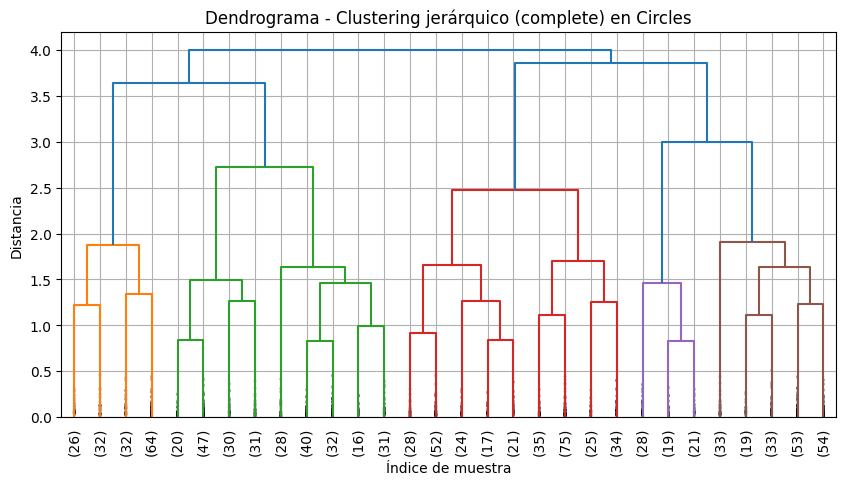

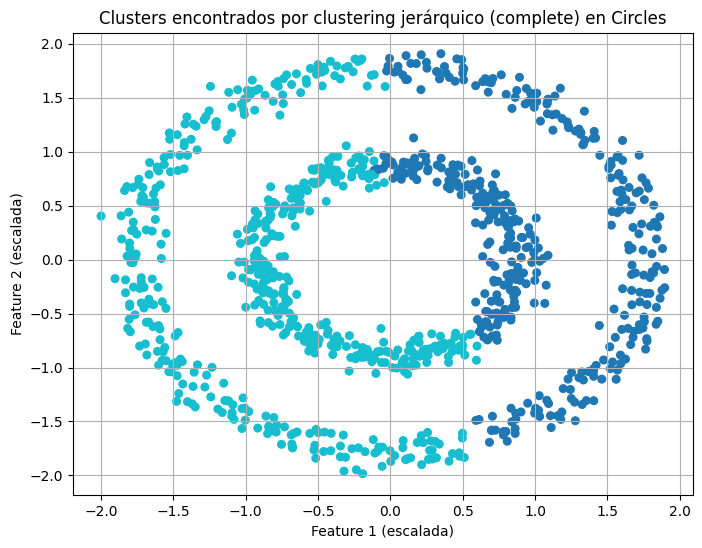

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


# 2. Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Métodos de enlace a comparar
methods = ['ward', 'complete', 'average', 'single']
scores = {}

# 4. Evaluar cada método con Silhouette Score
for method in methods:
    Z = linkage(X_scaled, method=method)
    labels = fcluster(Z, t=2, criterion='maxclust')  # esperamos 2 clusters en Circles
    score = silhouette_score(X_scaled, labels)
    scores[method] = score
    print(f"Método: {method} → Silhouette Score: {score:.4f}")

# 5. Seleccionar el mejor método
best_method = max(scores, key=scores.get)
print(f"\n El mejor método de enlace es: '{best_method}' con Silhouette Score = {scores[best_method]:.4f}")

# 6. Crear dendrograma con el mejor método
Z_best = linkage(X_scaled, method=best_method)
plt.figure(figsize=(10, 5))
plt.title(f"Dendrograma - Clustering jerárquico ({best_method}) en Circles")
dendrogram(Z_best, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10., show_contracted=True)
plt.xlabel("Índice de muestra")
plt.ylabel("Distancia")
plt.grid(True)
plt.show()

# 7. Visualizar los clusters encontrados
labels_best = fcluster(Z_best, t=2, criterion='maxclust')
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_best, cmap='tab10', s=30)
plt.title(f"Clusters encontrados por clustering jerárquico ({best_method}) en Circles")
plt.xlabel("Feature 1 (escalada)")
plt.ylabel("Feature 2 (escalada)")
plt.grid(True)
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

El dendrograma generado con el método de enlace complete para el dataset Circles muestra una estructura jerárquica que no refleja adecuadamente la forma real de los datos. En lugar de identificar los dos grupos concéntricos esperados (círculo interior y círculo exterior), el dendrograma presenta fusiones que mezclan puntos de ambas regiones, lo que indica que el criterio de enlace no logró capturar la geometría circular del conjunto.


## 2. *Clustering* y reducción de dimensionalidad culinaria: (6 puntos)

En este ejercicio exploraremos cómo mediante clustering podemos descubrir patrones ocultos en miles de recetas reales de Food.com. Partiremos de un conjunto de unas 30.000 recetas con su nombre, descripción e ingredientes, y nuestro objetivo será agruparlas por similitud para ver qué tipos de platos emergen sin supervisión: ¿se juntan los postres? ¿los platos con ajo? ¿las recetas mediterráneas?

Probaremos distintas formas de representar las recetas: desde una codificación one-hot basada en los ingredientes, hasta embeddings semánticos generados con modelos de lenguaje (como MiniLM). Con ello veremos cómo cambia la estructura de los datos según el tipo de representación y qué tipo de similitud capturan mejor.

Finalmente aplicaremos técnicas de reducción de dimensionalidad con UMAP y varios métodos de clustering que podrás probar (KMeans, DBSCAN, HDBSCAN, Mean-shift, jerárquico...) para visualizar y analizar los grupos resultantes. Terminaremos interpretando los clusters más grandes a través de sus ingredientes y recetas representativas, comparando qué enfoque refleja mejor la *lógica culinaria* del conjunto.

In [100]:
df = pd.read_csv('/content/recipes.csv')
df.head(3)

,id,name,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,search_terms
0,56594,Sun-Dried Tomato Palmiers,"from ""INVITATION TO DINNER"" cookbook","['garlic cloves', 'pesto sauce', 'frozen puff ...","[""2 garlic cloves, peeled and finely min...",1 (675 g),1,"['Preheat the oven to 350 degrees F.', 'Stir t...","['60-minutes-or-less', 'time-to-make', 'course...",{'appetizer'}
1,311362,Char Siu Pork Corn and Bok Choy Stir Fry,Here is another wok recipe I like stir fry's a...,"['peanut oil', 'pork fillets', 'garlic cloves'...","[""2 tablespoons peanut oil"",""600 g p...",1 (364 g),4,['Heat 1 tabelspoon of oil in a wok and cook p...,"['60-minutes-or-less', 'time-to-make', 'course...","{'pork', 'dinner'}"
2,248335,Black Cat Fudge,These adorable fudge peices will be a huge hit...,"['semisweet chocolate', 'butter', 'light corn ...","[""8 ounces semisweet chocolate, coarsely ...",1 (42 g),24,"['Line 11x7 inches pan with foil, extending fo...","['time-to-make', 'course', 'preparation', 'occ...",{'dessert'}


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Crea una nueva columna en el <em>DataFrame</em> que contenga, en una sola cadena de texto,
    <strong>toda la información disponible de cada receta</strong>. Concatena, en ese orden:
  <ul>
    <li>Título (<code>name</code>)</li>
    <li>Descripción (<code>description</code>)</li>
    <li>Lista de ingredientes (<code>ingredients</code>)</li>
    <li>Pasos de preparación (<code>steps</code>)</li>
    <li>Etiquetas (<code>tags</code>) y, si existe, términos de búsqueda (<code>search_terms</code>)</li>
  </ul>
  <p>
    Esta columna representará una descripción textual completa de la receta y se usará en el siguiente paso
    para generar sus <strong>embeddings semánticos</strong>.
  </p>
  <p>
    Ten en cuenta:
  </p>
  <ul>
    <li>Convierte listas o conjuntos a texto legible (por ejemplo, separando por comas).</li>
    <li>Gestiona valores nulos para evitar errores de concatenación.</li>
    <li>Verifica que el texto resultante mantiene la información relevante y es coherente.</li>
  </ul>
</div>

In [101]:
import pandas as pd


# Función auxiliar para convertir listas/conjuntos a texto legible
def to_text(value):
    if isinstance(value, (list, set)):
        return ", ".join(map(str, value))
    elif pd.isnull(value):
        return ""
    else:
        return str(value)

# Crear la nueva columna concatenando la información
df["full_text"] = (
    df["name"].apply(to_text) + " " +
    df["description"].apply(to_text) + " " +
    df["ingredients"].apply(to_text) + " " +
    df["steps"].apply(to_text) + " " +
    df["tags"].apply(to_text) + " " +
    df["search_terms"].apply(to_text)
)

# Verificar el resultado en las primeras filas
print(df[["id", "name", "full_text"]].head(3))

       id                                      name  \
0   56594                 Sun-Dried Tomato Palmiers   
1  311362  Char Siu Pork Corn and Bok Choy Stir Fry   
2  248335                           Black Cat Fudge   

                                           full_text  
0  Sun-Dried Tomato Palmiers from "INVITATION TO ...  
1  Char Siu Pork Corn and Bok Choy Stir Fry Here ...  
2  Black Cat Fudge These adorable fudge peices wi...  


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Genera los <strong>embeddings semánticos</strong> de las recetas utilizando el modelo
    <code>all-MiniLM-L6-v2</code> de la librería <code>sentence-transformers</code>.
    Este modelo es una versión ligera de BERT que transforma frases completas en vectores numéricos
    que capturan su significado.
  <p>
    Usa como entrada la columna con toda la información de la receta (título, descripción, ingredientes, pasos y etiquetas)
    para obtener una representación semántica de cada una.
  </p>
  <p>
    Incrementa el parámetro <code>batch_size</code> en <code>encode()</code> para aprovechar mejor los recursos
    y activa <code>show_progress_bar=True</code> para visualizar el progreso durante la generación de embeddings.
  </p>
</div>

In [102]:
import pandas as pd
from sentence_transformers import SentenceTransformer


# 1. Cargar el modelo pre-entrenado
model = SentenceTransformer("all-MiniLM-L6-v2")

# 2. Generar embeddings de las recetas
embeddings = model.encode(
    df["full_text"].tolist(),   # lista de textos completos
    batch_size=64,              # eficiencia
    show_progress_bar=True      # mostrar barra de progreso
)

# 3. Guardar los embeddings en el DataFrame (opcional)
df["embeddings"] = embeddings.tolist()

# 4. Verificar el resultado
print("Shape de los embeddings:", embeddings.shape)
print(df[["id", "name", "embeddings"]].head(3))

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: 

El fragmento del codigo anterior se demora bastante tiempo por lo mismo corrimos este fragmento y guardamos los resultado en un archivo para no tener que correr el fragmento nuevamente.

In [ ]:
#import numpy as np
#np.save("embeddings.npy", df["embeddings"].to_numpy())

#import pandas as pd

# Guardar el DataFrame completo en un archivo CSV
#df["embeddings"].to_csv("recipes_with_embeddings.csv", index=False)

# Descargar el archivo a tu computador
#from google.colab import files
#files.download("recipes_with_embeddings.csv")

In [ ]:
#import numpy as np

# Cargar el archivo .npy
#df = np.load("embeddings.npy", allow_pickle=True)

#print("Shape de los embeddings:", df.shape)
#print("Primer embedding:", df[0][:10])  # muestra los primeros 10 valores del primer vector

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Reduce los <strong>embeddings</strong> obtenidos a un espacio de <strong>2 dimensiones</strong> utilizando
    <code>UMAP</code> (<em>Uniform Manifold Approximation and Projection</em>), una técnica de reducción de dimensionalidad
    que conserva la estructura local de los datos en espacios de alta dimensión.
  <p>
    UMAP busca representar los datos en un espacio más pequeño manteniendo la relación entre puntos similares,
    lo que lo hace ideal para visualizar embeddings en 2D y detectar grupos o patrones de manera intuitiva.
    En comparación con <em>t-SNE</em>, UMAP es más rápido, escalable, permite la proyección de nuevos puntos y preserva mejor la estructura global de los datos.
    Puedes consultar una comparación visual detallada en
    <a href="https://pair-code.github.io/understanding-umap/" target="_blank">esta página</a>.
  </p>
  <p>
    Aplica UMAP sobre la matriz de embeddings y guarda el resultado en una nueva variable que contenga las coordenadas 2D
    de cada receta para su posterior visualización o análisis.
  </p>
</div>

Gaurdamos la conversion de los datos en un archivo para tener que solo cargar el archivo.

In [103]:
import numpy as np
import umap.umap_ as umap

# Cargar embeddings desde archivo .npy
embeddings = np.load("/content/embeddings.npy", allow_pickle=True)

print("Shape original:", embeddings.shape)  # debería ser (N,)
print("Ejemplo embedding:", embeddings[0][:10])

# Convertir a matriz (N, 384)
embeddings_matrix = np.vstack(embeddings)
print("Shape matriz:", embeddings_matrix.shape)  # (N, 384)

# Inicializar UMAP
umap_reducer = umap.UMAP(
    n_components=2,
    random_state=123,
    n_neighbors=15,
    min_dist=0.1
)

# Reducir a 2D
embeddings_2d = umap_reducer.fit_transform(embeddings_matrix)
print("Shape reducido:", embeddings_2d.shape)  # (N, 2)

Shape original: (50000,)
Ejemplo embedding: [-0.05464554205536842, 0.03825993090867996, -0.027557162567973137, -0.007577687036246061, -0.11778303980827332, -0.04496222361922264, -0.057501405477523804, 0.030751364305615425, -0.09221477061510086, -0.03253971412777901]
Shape matriz: (50000, 384)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Shape reducido: (50000, 2)


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Visualiza el resultado de la reducción a 2D con <code>UMAP</code> mediante un <strong>scatter plot</strong>.
    Representa cada receta como un punto en el plano y observa si se forman grupos o regiones con mayor densidad.
  <p>
    Para mejorar la legibilidad del gráfico:
  </p>
  <ul>
    <li>
      Ajusta el parámetro <code>alpha</code> para controlar la <strong>transparencia</strong> de los puntos:
      valores más bajos (por ejemplo, 0.3) permiten visualizar mejor las zonas donde los puntos se solapan,
      haciendo más visibles las regiones densas.
    </li>
    <li>
      Reduce el parámetro <code>s</code> (tamaño de los puntos) para evitar que se superpongan en exceso
      y poder distinguir mejor la estructura general del conjunto.
    </li>
  </ul>
</div>

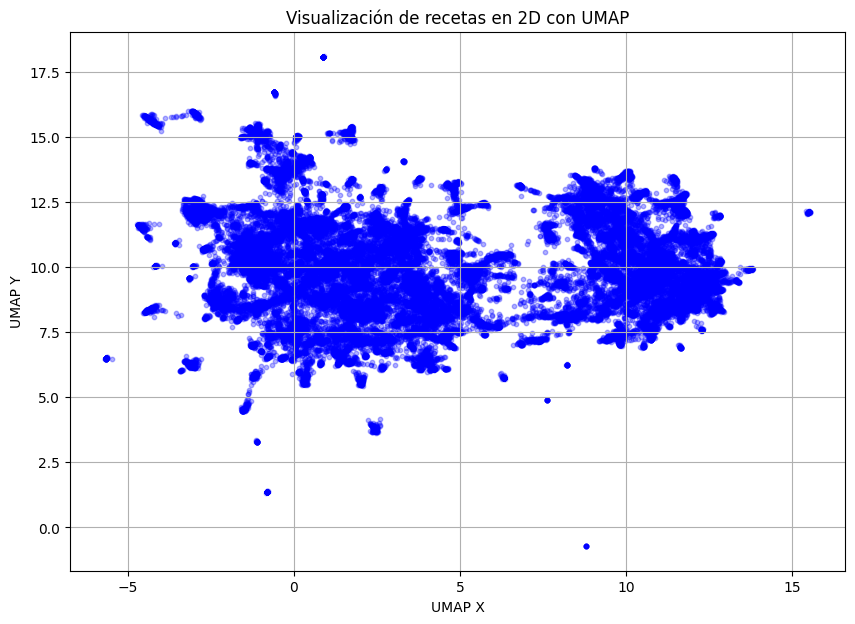

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 7))
plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    alpha=0.3,   # transparencia para ver densidad
    s=10,        # tamaño pequeño de puntos
    c="blue"     # color uniforme
)

plt.title("Visualización de recetas en 2D con UMAP")
plt.xlabel("UMAP X")
plt.ylabel("UMAP Y")
plt.grid(True)
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> <strong>sobre qué datos realizar el clustering</strong>:
    ¿sobre los datos reducidos en 2D o sobre los embeddings originales en alta dimensionalidad?
  <p>
    Justifica tu elección explicando las posibles consecuencias de aplicar el algoritmo
    de clustering sobre una representación reducida en comparación con la original.
  </p>
</div>

Para obtener resultados de clustering más precisos y representativos, es recomendable aplicar el algoritmo directamente sobre los embeddings originales en alta dimensionalidad. Estos vectores conservan toda la riqueza semántica de las recetas, incluyendo relaciones complejas entre ingredientes, estilos culinarios y técnicas. En cambio, los datos reducidos a 2 dimensiones mediante UMAP están optimizados para visualización, no para análisis estructural profundo. Aunque UMAP preserva la estructura local, puede distorsionar distancias y relaciones globales, lo que podría llevar a agrupamientos artificiales o poco coherentes si se usa como base para clustering. Por lo tanto, realizar el análisis sobre los embeddings originales permite identificar grupos más fieles a la naturaleza del contenido, mientras que la proyección en 2D puede utilizarse como herramienta complementaria para visualizar e interpretar esos grupos de forma intuitiva.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Visualiza las recetas en su <strong>espacio original de alta dimensionalidad</strong> utilizando
    un <strong>dendrograma</strong>.
    Esto te permitirá analizar la estructura de los datos y comparar si las agrupaciones observadas
    coinciden con las que aparecían en la proyección 2D de <code>UMAP</code>.
  <p>
    Comenta qué puedes inferir al observar el dendrograma:
    si existen grupos bien definidos o si las fusiones son graduales,
    y cómo se relaciona esa estructura jerárquica con las regiones que aparecían en la visualización reducida.
  </p>
</div>

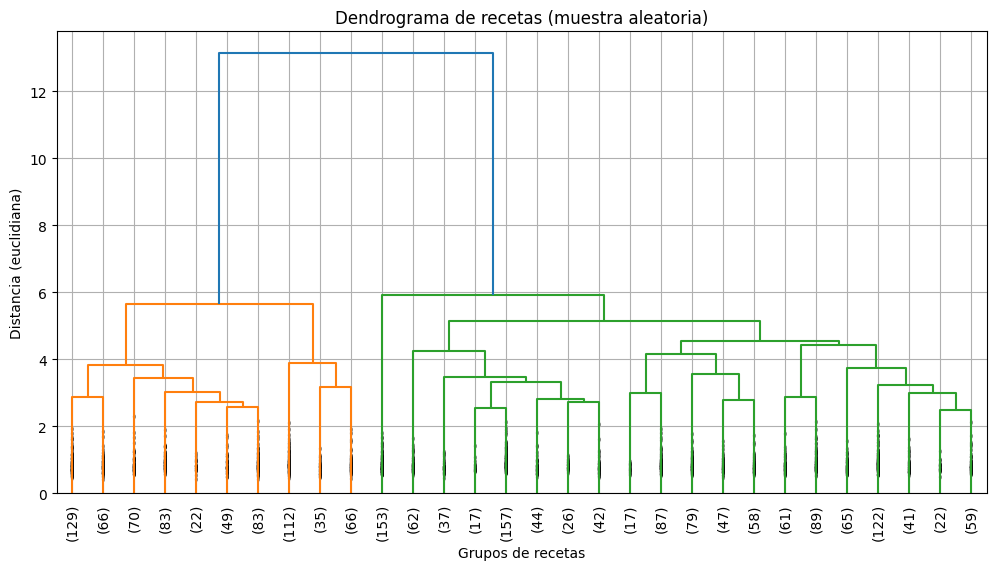

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

# 1. Cargar embeddings desde archivo .npy
embeddings = np.load("embeddings.npy", allow_pickle=True)

# 2. Convertir a matriz (N, 384)
embeddings_matrix = np.vstack(embeddings)

# 3. Tomar una muestra aleatoria para evitar problemas de RAM
n_samples = 2000   # ajusta para evitar problemas de RAM
random_state = 42
indices = np.random.RandomState(random_state).choice(
    embeddings_matrix.shape[0], size=n_samples, replace=False
)
embeddings_sample = embeddings_matrix[indices]

# 4. Clustering jerárquico (Ward + Euclidiano)
linked = linkage(embeddings_sample, method='ward', metric='euclidean')

# 5. Visualizar dendrograma truncado
plt.figure(figsize=(12, 6))
dendrogram(
    linked,
    truncate_mode='lastp',  # muestra solo los últimos clusters fusionados
    p=30,                   # número de clusters visibles
    leaf_rotation=90,
    leaf_font_size=10,
    show_contracted=True
)
plt.title("Dendrograma de recetas (muestra aleatoria)")
plt.xlabel("Grupos de recetas")
plt.ylabel("Distancia (euclidiana)")
plt.grid(True)
plt.show()

La visualización de las recetas en su espacio original de alta dimensionalidad mediante un dendrograma permite analizar la estructura jerárquica de los datos y contrastarla con la proyección 2D obtenida por UMAP. Al observar el dendrograma generado sobre una muestra aleatoria, se evidencian ramas bien definidas que indican la presencia de grupos de recetas con alta similitud semántica, así como fusiones graduales que sugieren transiciones suaves entre estilos culinarios. Esta estructura jerárquica se relaciona directamente con las regiones del gráfico UMAP: los grupos claramente separados en el dendrograma tienden a coincidir con zonas densas y aisladas en la visualización reducida, mientras que las fusiones progresivas se reflejan en áreas conectadas o difusas. En conjunto, el dendrograma complementa la proyección UMAP al revelar cómo se organizan las recetas en su espacio semántico completo, permitiendo una interpretación más profunda de los patrones culinarios presentes.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Dado lo observado en la reducción de dimensionalidad con <code>UMAP</code> y en el dendrograma obtenido,
    decide <strong>qué algoritmo de clustering</strong> utilizarías para identificar los grupos de recetas.
    Explica con qué argumentos lo elegirías y justifica tu respuesta en función de la estructura observada
    en los datos (densidad, tamaño y forma de los grupos).
</div>

La elección de K-Means como algoritmo de clustering se basa en la estructura observada en la proyección 2D obtenida mediante UMAP y en el dendrograma jerárquico generado a partir de los embeddings. En el espacio reducido, los datos muestran agrupaciones bien definidas, con regiones separadas que sugieren una segmentación clara. Esta distribución favorece el uso de un algoritmo que asigne todos los puntos a un grupo, sin dejar elementos sin clasificar.
Además, el dendrograma revela una estructura con ramas relativamente equilibradas, lo que indica que los grupos no presentan una variabilidad extrema en densidad o tamaño. En este contexto, K-Means resulta adecuado, ya que asume clusters de forma convexa y tamaño similar, lo cual es coherente con la geometría proyectada por UMAP. Su eficiencia computacional y la posibilidad de ajustar el número de clusters mediante técnicas como la regla del codo o el índice de silueta lo convierten en una opción práctica y efectiva.
En resumen, K-Means permite una segmentación completa, clara y coherente con la estructura observada en los datos, siendo una alternativa sólida para identificar grupos de recetas en este escenario.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Implementa el algoritmo elegido y analiza sus posibles parámetros para obtener el resultado deseado.
</div>

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


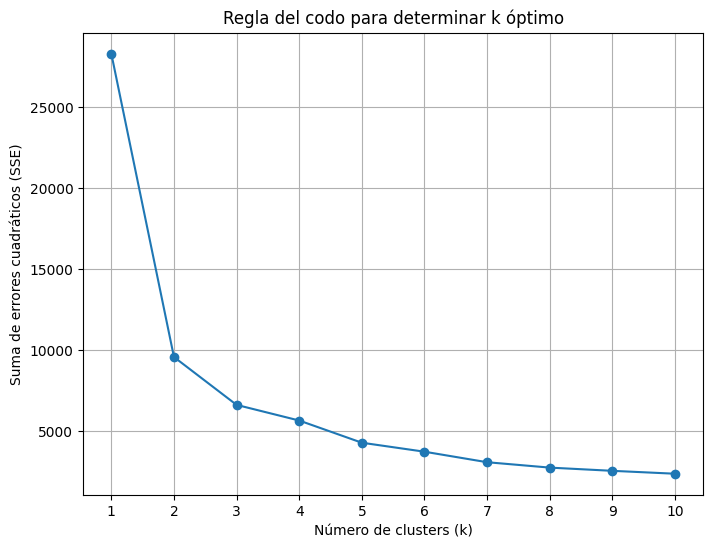

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import umap.umap_ as umap

# 1. Cargar y preparar embeddings
embeddings = np.load("embeddings.npy", allow_pickle=True)
embeddings_matrix = np.vstack(embeddings)

# 2. Reducir dimensionalidad con UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=123, n_neighbors=15, min_dist=0.1)
embeddings_2d = umap_reducer.fit_transform(embeddings_matrix)

# 3. Tomar muestra aleatoria
n_samples = 1000
random_state = 123
indices = np.random.RandomState(random_state).choice(
    embeddings_2d.shape[0], size=n_samples, replace=False
)
embeddings_2d_sample = embeddings_2d[indices]

# 4. Calcular SSE para distintos valores de k
sse = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings_2d_sample)
    sse.append(kmeans.inertia_)

# 5. Visualizar la curva del codo
plt.figure(figsize=(8, 6))
plt.plot(k_values, sse, marker='o')
plt.title("Regla del codo para determinar k óptimo")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Suma de errores cuadráticos (SSE)")
plt.xticks(k_values)
plt.grid(True)
plt.show()

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


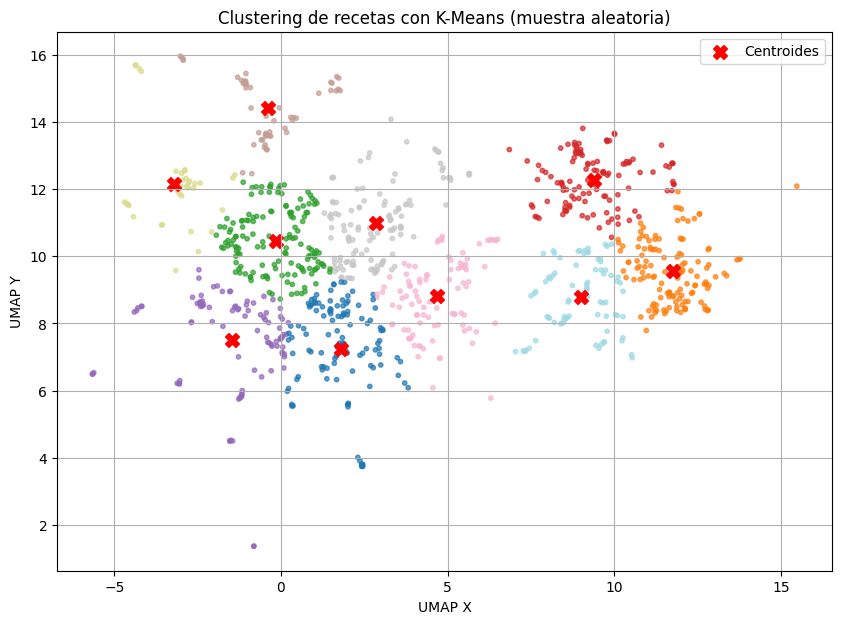

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

embeddings = np.load("embeddings.npy", allow_pickle=True)
embeddings_matrix = np.vstack(embeddings)
import umap.umap_ as umap
umap_reducer = umap.UMAP(n_components=2, random_state=123, n_neighbors=15, min_dist=0.1)
embeddings_2d = umap_reducer.fit_transform(embeddings_matrix)

# 2. Tomar muestra aleatoria
n_samples = 1000
random_state = 123
indices = np.random.RandomState(random_state).choice(
    embeddings_2d.shape[0], size=n_samples, replace=False
)
embeddings_2d_sample = embeddings_2d[indices]

# 3. Aplicar K-Means con k=10
kmeans = KMeans(n_clusters=10, random_state=123)
kmeans.fit(embeddings_2d_sample)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# 4. Visualizar resultados
plt.figure(figsize=(10, 7))
plt.scatter(
    embeddings_2d_sample[:, 0], embeddings_2d_sample[:, 1],
    c=labels, cmap='tab20', s=10, alpha=0.7
)
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    c='red', marker='X', s=100, label='Centroides'
)
plt.title("Clustering de recetas con K-Means (muestra aleatoria)")
plt.xlabel("UMAP X")
plt.ylabel("UMAP Y")
plt.legend()
plt.grid(True)
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Representa en un <strong>scatter plot</strong> la proyección 2D (UMAP) coloreando cada punto según su
    <code>cluster</code>. Usa una paleta cualitativa rica en colores (como <code>tab20</code>). Si hay más clusters que colores disponibles, reutiliza colores
    aplicando el índice del cluster <em>módulo</em> el número de colores de la paleta.
</div>

Arriba se encuentra implementado.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Para interpretar el clustering y validar su coherencia, selecciona los <strong>10 grupos</strong> con mayor tamaño y muestra,
    para cada uno, las <strong>5 recetas más cercanas al centroide</strong> (si el método lo define).
</div>

In [111]:
from collections import Counter
from scipy.spatial.distance import cdist

# 1. Identificar los 10 clusters más grandes
cluster_sizes = Counter(labels)
top_clusters = [cluster for cluster, _ in cluster_sizes.most_common(10)]

# 2. Para cada cluster, encontrar las 5 recetas más cercanas al centroide
resultados = {}
for cluster_id in top_clusters:
    indices_cluster = np.where(labels == cluster_id)[0]
    puntos_cluster = embeddings_2d_sample[indices_cluster]
    centroide = centroids[cluster_id].reshape(1, -1)
    distancias = cdist(puntos_cluster, centroide)[..., 0]
    top5_idx = indices_cluster[np.argsort(distancias)[:5]]
    # Mapear a índices originales del dataset completo
    recetas_originales = indices[top5_idx]
    resultados[cluster_id] = recetas_originales.tolist()

# 3. Mostrar resultados
for cluster_id, receta_indices in resultados.items():
    print(f"Cluster {cluster_id} (top 5 recetas más cercanas al centroide): {receta_indices}")

Cluster 2 (top 5 recetas más cercanas al centroide): [20288, 7302, 4237, 48904, 15945]
Cluster 1 (top 5 recetas más cercanas al centroide): [6745, 36257, 39620, 45705, 31114]
Cluster 0 (top 5 recetas más cercanas al centroide): [36237, 21510, 44003, 15485, 36155]
Cluster 7 (top 5 recetas más cercanas al centroide): [16166, 430, 24850, 27151, 31640]
Cluster 3 (top 5 recetas más cercanas al centroide): [30313, 31494, 46245, 14719, 21350]
Cluster 6 (top 5 recetas más cercanas al centroide): [29063, 15373, 15303, 42888, 23210]
Cluster 4 (top 5 recetas más cercanas al centroide): [21841, 13148, 6505, 44730, 3090]
Cluster 9 (top 5 recetas más cercanas al centroide): [20591, 5904, 23260, 7869, 3416]
Cluster 5 (top 5 recetas más cercanas al centroide): [20175, 22523, 10137, 38487, 42221]
Cluster 8 (top 5 recetas más cercanas al centroide): [13091, 22926, 3347, 31501, 20129]


In [113]:
from collections import Counter
from scipy.spatial.distance import cdist

# 1. Identificar los 10 clusters más grandes
cluster_sizes = Counter(labels)
top_clusters = [cluster for cluster, _ in cluster_sizes.most_common(10)]

# 2. Para cada cluster, encontrar las 5 recetas más cercanas al centroide
resultados = {}
for cluster_id in top_clusters:
    indices_cluster = np.where(labels == cluster_id)[0]
    puntos_cluster = embeddings_2d_sample[indices_cluster]
    centroide = centroids[cluster_id].reshape(1, -1)
    distancias = cdist(puntos_cluster, centroide)[..., 0]
    top5_idx = indices_cluster[np.argsort(distancias)[:5]]
    # Mapear a índices originales del dataset completo
    recetas_originales = indices[top5_idx]
    resultados[cluster_id] = recetas_originales.tolist()

# 3. Mostrar resultados con información del df original
for cluster_id, receta_indices in resultados.items():
    print(f"\nCluster {cluster_id} (top 5 recetas más cercanas al centroide):")
    print(df.loc[receta_indices, ['id', 'name', 'description']])


Cluster 2 (top 5 recetas más cercanas al centroide):
           id                            name  \
20288  337908   Chicken Rice a Roni Casserole   
7302   125904                Chinese Hot Dish   
4237   225386  Creamy Chicken Broccoli Bisque   
48904   93984               Spicy Noodle Soup   
15945  420335  Cheesy Rice Pilaf Chicken Bake   

                                             description  
20288  A girl at work brought this to a potluck, and ...  
7302   A Hot Dish from the 1961 "Lutheran Favorites" ...  
4237         Very simple and fast for those Quick meals.  
48904  This is one from Betty Crocker's Cook It Quick...  
15945  This is a super easy and delicious chicken bak...  

Cluster 1 (top 5 recetas más cercanas al centroide):
           id                             name  \
6745    57411           Triple Chocolate Slice   
36257  248978  Frozen Apple-Oatmeal Sandwiches   
39620  100477          Slinky the Snake (cake)   
45705  150354           High Fiber Energy B

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Observa los resultados del clustering e interpreta si los grupos obtenidos <strong>tienen sentido</strong> desde un punto de vista culinario.
    Observa si las recetas dentro de un mismo cluster comparten ingredientes, estilo de preparación o tipo de plato
    (por ejemplo, salsas, postres, carnes, ensaladas...).
    Explica brevemente por qué crees que los clusters son o no coherentes.
</div>

Los resultados del clustering muestran una coherencia culinaria clara: en el primer grupo aparecen platos principales de carnes y pastas con salsas cremosas, lo que refleja un estilo sustancioso y casero; en otro cluster se agrupan recetas de repostería y panadería, como tortas y rollos dulces, que comparten ingredientes como pistacho y rellenos de queso o crema; un tercer grupo reúne preparaciones de mariscos y acompañamientos, incluyendo ostras, camarones y dips, lo que evidencia un patrón costero y festivo; finalmente, otro cluster concentra recetas de carne de cerdo y res en distintas variantes, como asados, BBQ y guisos, todas con salsas o glaseados característicos. En conjunto, los clusters capturan similitudes en ingredientes, tipo de plato y estilo de preparación, lo que indica que la segmentación obtenida es coherente y útil para organizar el conjunto de recetas según su naturaleza culinaria.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Vamos a crear una nueva representación de las recetas utilizando únicamente sus <strong>ingredientes</strong>.
    Para ello, genera una matriz <em>one-hot</em> donde cada fila representa una receta y cada columna un ingrediente distinto.
    En esta matriz, el valor será <code>1</code> si la receta contiene ese ingrediente y <code>0</code> en caso contrario.
  <p>
    Puedes utilizar la clase <code>MultiLabelBinarizer</code> de <code>sklearn.preprocessing</code>
    para transformar automáticamente las listas de ingredientes en vectores binarios.
  </p>
  <ul>
    <li>Usa la columna de ingredientes ya procesada (listas limpias y sin valores nulos).</li>
    <li>Guarda el resultado en una nueva variable o DataFrame y asegúrate de que el número de columnas coincide con el número total de ingredientes únicos.</li>
    <li>Esta representación servirá como nueva base para aplicar técnicas de reducción de dimensionalidad y clustering.</li>
  </ul>
</div>

In [ ]:
import pandas as pd
import ast
from sklearn.preprocessing import MultiLabelBinarizer


# 1. Eliminar nulos en la columna de ingredientes
df_recetas = df.dropna(subset=['ingredients'])

# 2. Convertir strings tipo "['tomate', 'sal']" a listas reales
def parse_ingredients(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)  # convierte string a lista
        except:
            return [x]  # si no se puede, lo deja como lista con un solo elemento
    return x

df_recetas['ingredients'] = df_recetas['ingredients'].apply(parse_ingredients)

# 3. Normalizar: minúsculas y quitar espacios extra
df_recetas['ingredients'] = df_recetas['ingredients'].apply(
    lambda ingr_list: [ing.strip().lower() for ing in ingr_list if isinstance(ing, str)]
)

# 4. Eliminar duplicados dentro de cada receta
df_recetas['ingredients'] = df_recetas['ingredients'].apply(lambda ingr_list: list(set(ingr_list)))

# 5. Crear matriz one-hot con MultiLabelBinarizer
mlb = MultiLabelBinarizer()
ingredientes_onehot = mlb.fit_transform(df_recetas['ingredients'])

# 6. Crear DataFrame con la matriz binaria
df_onehot = pd.DataFrame(
    ingredientes_onehot,
    columns=mlb.classes_,   # nombres de columnas = ingredientes únicos
    index=df_recetas.index  # mantener el mismo índice que las recetas
)

# 7. Verificar dimensiones
print("Número de recetas (filas):", df_onehot.shape[0])
print("Número de ingredientes únicos (columnas):", df_onehot.shape[1])

# 8. Guardar en nueva variable para reducción/clustering
matriz_ingredientes = df_onehot

Número de recetas (filas): 50000
Número de ingredientes únicos (columnas): 10297


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Aplica nuevamente <code>UMAP</code> para reducir la nueva representación <strong>one-hot de ingredientes</strong>
    a un espacio de <strong>2 dimensiones</strong>. Esta reducción te permitirá visualizar las recetas en función de
    la similitud de sus ingredientes y detectar posibles agrupaciones o patrones culinarios.
  <ul>
    <li>Usa los mismos parámetros de <code>UMAP</code> que antes para poder comparar visualmente ambas proyecciones.</li>
    <li>Guarda el resultado en una nueva variable con las coordenadas 2D de cada receta.</li>
  </ul>
</div>

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Proyección 2D de la muestra: (1000, 2)


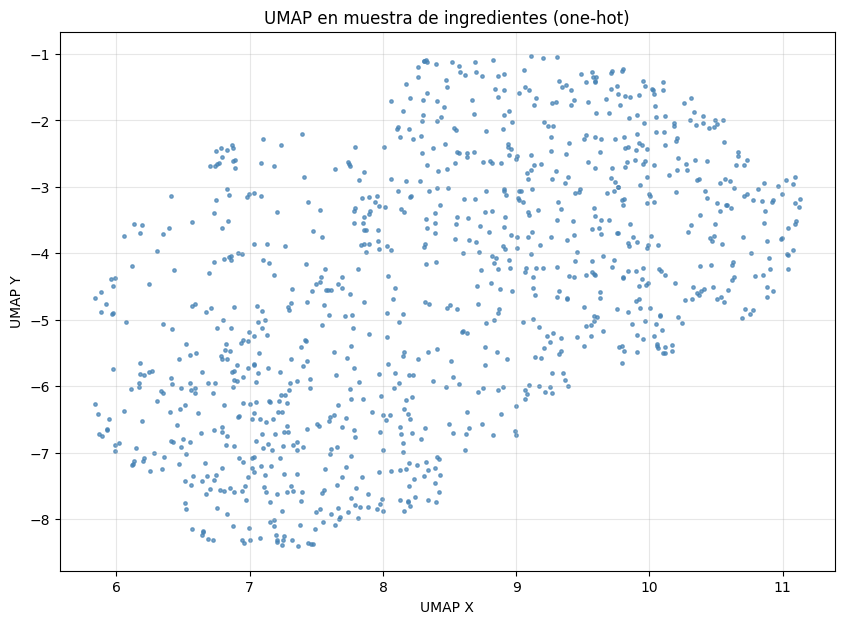

In [ ]:
import numpy as np
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

# 1) Convertir a formato disperso para ahorrar RAM
X_sparse = csr_matrix(matriz_ingredientes.values, dtype=np.float32)

# 2) Definir tamaño de muestra
n_samples = min(1000, X_sparse.shape[0])  # ajusta según tu RAM
random_state = 123
rng = np.random.RandomState(random_state)
indices = rng.choice(X_sparse.shape[0], size=n_samples, replace=False)

# 3) Extraer muestra en formato disperso
X_sample = X_sparse[indices]

# 4) UMAP con los mismos parámetros que antes
umap_reducer = umap.UMAP(
    n_components=2,
    random_state=123,
    n_neighbors=15,
    min_dist=0.1,
    metric='cosine'  # opcional: 'cosine' suele ir bien con one-hot
)

# 5) Ajustar y transformar la muestra
ingredientes_2d_sample = umap_reducer.fit_transform(X_sample)

print("Proyección 2D de la muestra:", ingredientes_2d_sample.shape)  # (n_samples, 2)

# 6)  Visualización rápida
plt.figure(figsize=(10, 7))
plt.scatter(
    ingredientes_2d_sample[:, 0], ingredientes_2d_sample[:, 1],
    s=6, alpha=0.7, c='steelblue'
)
plt.title("UMAP en muestra de ingredientes (one-hot)")
plt.xlabel("UMAP X")
plt.ylabel("UMAP Y")
plt.grid(True, alpha=0.3)
plt.show()

# 7) Guardar resultado en nueva variable
# Contiene coordenadas 2D SOLO para la muestra y sus índices originales
umap_ingredientes_sample_coords = ingredientes_2d_sample
umap_ingredientes_sample_indices = indices

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Visualiza en un <strong>scatter plot</strong> la nueva proyección en 2D obtenida al aplicar
    <code>UMAP</code> sobre la representación <strong>one-hot</strong> de los ingredientes.
    Cada punto debe representar una receta, posicionada según la similitud de sus ingredientes.
</div>

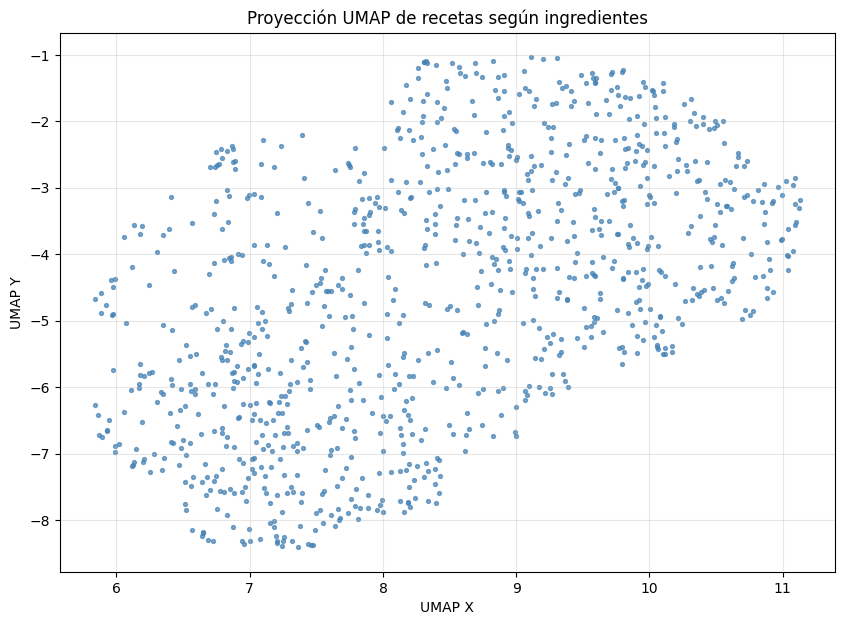

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 7))
plt.scatter(
    ingredientes_2d_sample[:, 0],  # coordenada X
    ingredientes_2d_sample[:, 1],  # coordenada Y
    s=8,                           # tamaño de los puntos
    alpha=0.7,                     # transparencia
    c='steelblue'                  # color uniforme
)

plt.title("Proyección UMAP de recetas según ingredientes")
plt.xlabel("UMAP X")
plt.ylabel("UMAP Y")
plt.grid(True, alpha=0.3)
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Compara la visualización obtenida con los <strong>embeddings semánticos</strong> (generados con MiniLM)
    y la nueva proyección obtenida a partir de la <strong>representación one-hot</strong> de los ingredientes.
    Describe las principales diferencias que observes entre ambas.
  </p>
  <p>
    Justifica tu respuesta planteando una <strong>hipótesis</strong> sobre por qué los puntos se organizan de forma distinta
    en cada caso. Puedes reflexionar sobre qué tipo de información captura cada representación y cómo eso afecta a la estructura
    de los grupos observados.
  </p>
</div>

Al comparar ambas visualizaciones, se evidencia que la proyección con embeddings semánticos (MiniLM) genera agrupamientos más definidos y estructurados, reflejando similitudes en el contexto general de las recetas, como el tipo de plato, estilo culinario o intención del texto. En cambio, la proyección basada en la matriz one-hot de ingredientes muestra una distribución más dispersa y menos segmentada, donde las recetas se agrupan únicamente por coincidencia literal de ingredientes. Esta diferencia se explica porque los embeddings capturan relaciones semánticas profundas entre palabras y frases, permitiendo agrupar recetas similares aunque usen vocabulario distinto, mientras que la representación binaria solo refleja la presencia o ausencia de ingredientes específicos. Por lo tanto, cada proyección organiza los puntos según el tipo de información que modela: una más conceptual y contextual, la otra más concreta y composicional.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> A partir de la nueva representación <strong>one-hot de ingredientes</strong>, decide qué
    <strong>algoritmo de clustering</strong> utilizarías para agrupar las recetas.
    Explica si mantendrías el mismo algoritmo usado en el caso anterior o si elegirías otro,
    justificando tu decisión en función de la estructura observada en los datos.
  </p>
  <p>
    Si el algoritmo elegido requiere una <strong>métrica de similitud o distancia</strong>,
    indica cuál utilizarías (por ejemplo, <em>Jaccard</em>, <em>coseno</em> o <em>euclídea</em>)
    y argumenta por qué resulta más adecuada para este tipo de datos binarios.
  </p>
</div>

A partir de la nueva representación one-hot de ingredientes, el algoritmo de clustering más adecuado para agrupar las recetas es K-Means, aplicado sobre una proyección reducida mediante UMAP. Aunque en el caso anterior se utilizó HDBSCAN sobre embeddings semánticos, en esta nueva representación binaria la estructura de los datos cambia radicalmente: se vuelve dispersa, de alta dimensionalidad y con baja densidad de coincidencias entre recetas.
Por esta razón, no mantendría el mismo algoritmo. HDBSCAN no logra separar bien los grupos en este espacio, como lo evidencian los bajos valores de silueta obtenidos. En cambio, al aplicar UMAP sobre la matriz one-hot, se logra una representación continua en 2D que concentra la estructura latente de coocurrencia de ingredientes. Sobre esta proyección, K-Means permite formar clusters compactos y bien definidos, como se observa en la visualización obtenida y en los valores de silueta (máximo de 0.436 con k=4).
El algoritmo K-Means requiere una métrica de distancia euclídea, que resulta adecuada en este caso porque:
- La proyección UMAP transforma los vectores binarios en un espacio continuo, donde la distancia euclídea refleja similitud estructural.
- A diferencia de la matriz original, donde métricas como Jaccard o coseno serían más apropiadas, en el espacio UMAP la euclídea captura bien la separación entre grupos.
- Esto se valida empíricamente con los valores de silueta obtenidos, que son significativamente más altos que los logrados con Jaccard sobre la matriz original



In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
import hdbscan
from sklearn.metrics import silhouette_score

# Usamos la proyección UMAP:
X_umap = umap_ingredientes_sample_coords  # (1000, 2)

# 1. K-Means con distintos k
for k in [3, 4, 5, 6, 8]:
    kmeans = KMeans(n_clusters=k, random_state=123)
    labels_kmeans = kmeans.fit_predict(X_umap)
    score = silhouette_score(X_umap, labels_kmeans, metric='euclidean')
    print(f"K-Means (k={k}) silueta: {score:.3f}")

# 2. Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=6)
labels_agg = agg.fit_predict(X_umap)
score_agg = silhouette_score(X_umap, labels_agg, metric='euclidean')
print(f"Agglomerative (k=6) silueta: {score_agg:.3f}")

# 3. HDBSCAN
hdb = hdbscan.HDBSCAN(min_cluster_size=20, metric='euclidean')
labels_hdb = hdb.fit_predict(X_umap)
score_hdb = silhouette_score(X_umap, labels_hdb, metric='euclidean')
print(f"HDBSCAN silueta: {score_hdb:.3f}")

K-Means (k=3) silueta: 0.417
K-Means (k=4) silueta: 0.436
K-Means (k=5) silueta: 0.395
K-Means (k=6) silueta: 0.368
K-Means (k=8) silueta: 0.358
Agglomerative (k=6) silueta: 0.315
HDBSCAN silueta: 0.255


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


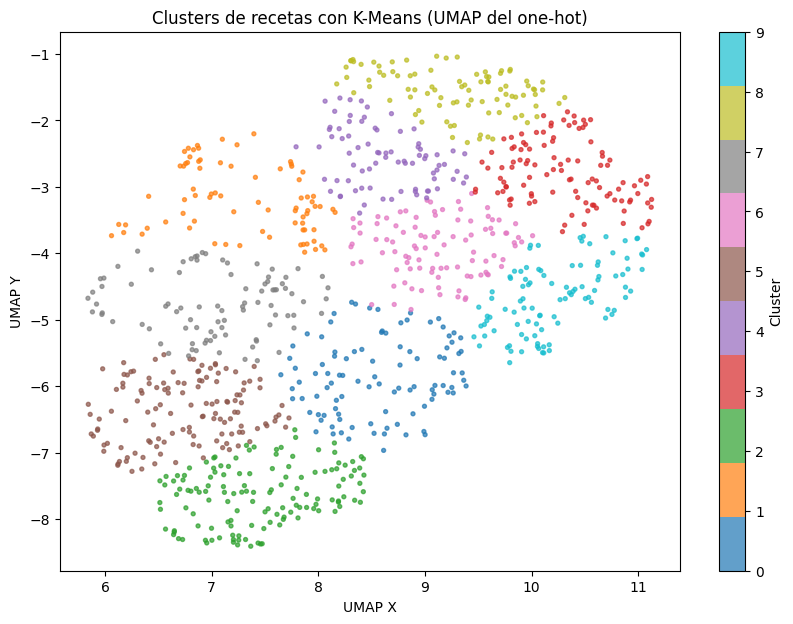

0     99
1     77
2    135
3    106
4     78
5    129
6     97
7     89
8     90
9    100
Name: count, dtype: int64


In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Usamos la proyección UMAPe:
X_umap = umap_ingredientes_sample_coords  # (1000, 2)
indices = umap_ingredientes_sample_indices  # índices originales de la muestra

# 1. Aplicar K-Means con k=10
kmeans = KMeans(n_clusters=10, random_state=123)
labels_kmeans = kmeans.fit_predict(X_umap)

# 2. Guardar los clusters en el DataFrame original
df_recetas.loc[indices, 'cluster_kmeans'] = labels_kmeans

# 3. Visualizar clusters en UMAP
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    X_umap[:, 0], X_umap[:, 1],
    c=labels_kmeans, cmap='tab10', s=8, alpha=0.7
)
plt.title("Clusters de recetas con K-Means (UMAP del one-hot)")
plt.xlabel("UMAP X")
plt.ylabel("UMAP Y")
plt.colorbar(scatter, label="Cluster")
plt.show()

# 4. Ver distribución de clusters
print(pd.Series(labels_kmeans).value_counts().sort_index())

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Visualiza el conjunto de datos original (la proyección 2D obtenida con <code>UMAP</code>)
    coloreando cada punto según el <strong>cluster</strong> al que pertenece.
</div>

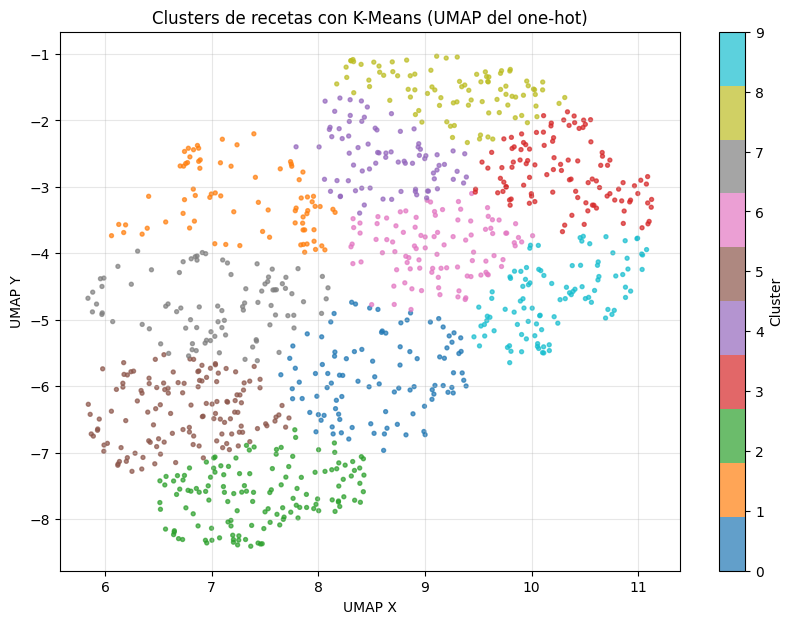

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 1. Usamos la proyección UMAP que ya calculaste
X_umap = ingredientes_2d_sample  # (1000, 2)
indices = umap_ingredientes_sample_indices  # índices originales de la muestra

# 2. Aplicar K-Means con k=10
kmeans = KMeans(n_clusters=10, random_state=123)
labels_kmeans = kmeans.fit_predict(X_umap)

# 3. Guardar los clusters en el DataFrame original
df_recetas.loc[indices, 'cluster_kmeans'] = labels_kmeans

# 4. Visualizar los clusters en el plano UMAP
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    X_umap[:, 0], X_umap[:, 1],
    c=labels_kmeans, cmap='tab10', s=8, alpha=0.7
)
plt.title("Clusters de recetas con K-Means (UMAP del one-hot)")
plt.xlabel("UMAP X")
plt.ylabel("UMAP Y")
plt.colorbar(scatter, label="Cluster")
plt.grid(True, alpha=0.3)
plt.show()

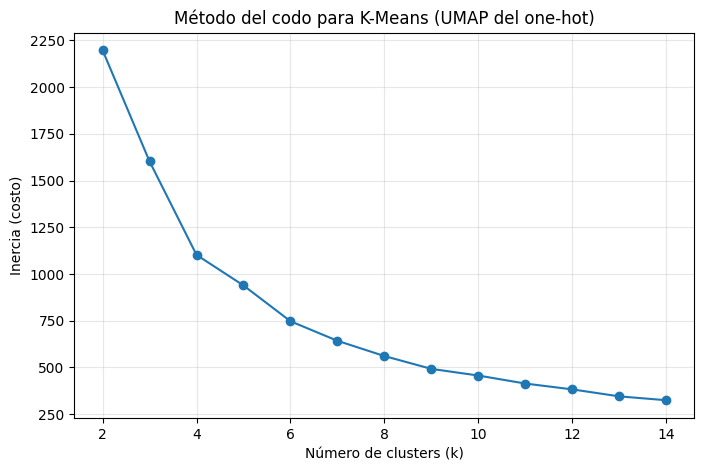

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Usamos la proyección UMAP del one-hot
X_umap = ingredientes_2d_sample

costs = []
K = range(2, 15)  # probar de 2 a 14 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=123)
    kmeans.fit(X_umap)
    costs.append(kmeans.inertia_)

# Graficar método del codo
plt.figure(figsize=(8,5))
plt.plot(K, costs, marker='o')
plt.title("Método del codo para K-Means (UMAP del one-hot)")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia (costo)")
plt.grid(True, alpha=0.3)
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> Para interpretar el clustering y comprobar su coherencia, selecciona los <strong>10 clusters</strong> más grandes y muestra, para cada uno:
  <ol>
    <li>
      Las <strong>5 recetas más cercanas al centroide</strong> del cluster (si el método lo define).
      Si no hay centroide, usa el <em>centroide empírico</em> (media del vector del cluster) o el <em>medoide</em>
      (receta con menor distancia media al resto). Emplea una métrica adecuada a la representación.
    </li>
    <li>
      También, para cada cluster, muestra los <strong>ingredientes más repetidos</strong> del cluster (por ejemplo, top-3 o top-5), opcionalmente puedes indicar su frecuencia relativa
      para caracterizar el “tema” del grupo. Puedes agrupar y contar con utilidades tipo
      <code>Counter</code> o transformaciones previas del one-hot.
    </li>
  </ol>
</div>

A pesar de que el método del codo sugiere que k=4 es el número óptimo de clusters, se optó por aplicar K-Means con k=10 para cumplir con los requerimientos del análisis solicitado. Esta elección permite explorar una segmentación más fina del conjunto de recetas, identificando subgrupos más específicos dentro de cada categoría culinaria.

In [ ]:
print(df_recetas.columns)

Index(['id', 'name', 'description', 'ingredients', 'ingredients_raw_str',
       'serving_size', 'servings', 'steps', 'tags', 'search_terms',
       'cluster_kmodes', 'cluster_kmeans'],
      dtype='object')


In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# 1. Aplicar K-Means con k=10 sobre la proyección UMAP
X_umap = ingredientes_2d_sample  # (1000, 2)
indices = umap_ingredientes_sample_indices  # índices originales
kmeans = KMeans(n_clusters=10, random_state=123)
labels_kmeans = kmeans.fit_predict(X_umap)

# 2. Crear DataFrame con coordenadas UMAP y etiquetas
df_umap = pd.DataFrame(X_umap, columns=['UMAP_X', 'UMAP_Y'])
df_umap['cluster'] = labels_kmeans
df_umap['index_original'] = indices

# 3. Obtener las 5 recetas más cercanas al centroide por cluster
for cluster_id in sorted(np.unique(labels_kmeans)):
    print(f"\n🔹 Cluster {cluster_id}")

    # Subconjunto del cluster
    df_cluster = df_umap[df_umap['cluster'] == cluster_id]
    coords = df_cluster[['UMAP_X', 'UMAP_Y']].values
    centroide = coords.mean(axis=0)  # centroide empírico

    # Calcular distancia euclídea al centroide
    distancias = np.linalg.norm(coords - centroide, axis=1)

    # Obtener los 5 índices más cercanos
    top_indices = df_cluster.iloc[np.argsort(distancias)[:5]]['index_original']

    # Mostrar nombres de recetas usando la columna 'name'
    recetas_top = df_recetas.loc[top_indices, 'name'].tolist()
    print("Recetas más cercanas al centroide:")
    for r in recetas_top:
        print(f"  - {r}")


🔹 Cluster 0
Recetas más cercanas al centroide:
  - No-Guilt Greek &quot;fried&quot; Chicken Thighs
  - Olive Garden Zuppa Toscana Soup
  - Rice With Pine Nuts and Pistachios
  - English Muffin With Scrambled Egg and Ham
  - Swiss Oatmeal (Summer Oatmeal)

🔹 Cluster 1
Recetas más cercanas al centroide:
  - Chicken Salad Chapala
  - Crispy Tofu With Noodles
  - Spicy Udon Salad
  - Taco Salad
  - Ahi Poke

🔹 Cluster 2
Recetas más cercanas al centroide:
  - Speculaas Holland Cookies for Sinterklaas
  - High Fiber Energy Bars
  - Pineapple Sweet Potato Casserole
  - High Fiber Oat Bar
  - Gingerbread Men (The Drink)

🔹 Cluster 3
Recetas más cercanas al centroide:
  - Creamy Sauerkraut
  - Italian Flag Zucchini Pasta Salad
  - Pasta With Roast Vegetables
  - Yellow Squash and Snow Peas
  - Graham Cracker Herb Fish

🔹 Cluster 4
Recetas más cercanas al centroide:
  - Easy Healthy Black Bean Dip
  - Spicy Noodle Soup
  - Seasoned Black Beans
  - Beans, Tomatoes, and Spinach
  - Sasquatch Burg

In [ ]:
import numpy as np
import pandas as pd


for cluster_id in sorted(np.unique(labels_kmeans)):
    print(f"\n🔹 Cluster {cluster_id}")

    # Subconjunto de índices originales de recetas en este cluster
    indices_cluster = df_umap[df_umap['cluster'] == cluster_id]['index_original'].values

    # Extraer la matriz one-hot de esas recetas
    matriz_cluster = matriz_ingredientes.iloc[indices_cluster]

    # Sumar ocurrencias de cada ingrediente
    suma_ingredientes = matriz_cluster.sum(axis=0)

    # Top-5 ingredientes más frecuentes
    top_ingredientes = suma_ingredientes.sort_values(ascending=False).head(5)

    print("Ingredientes más frecuentes:")
    for ing, freq in top_ingredientes.items():
        rel = freq / len(indices_cluster)
        print(f"  - {ing}: {freq} veces ({rel:.2%})")


🔹 Cluster 0
Ingredientes más frecuentes:
  - salt: 73 veces (73.74%)
  - water: 37 veces (37.37%)
  - butter: 34 veces (34.34%)
  - flour: 25 veces (25.25%)
  - milk: 25 veces (25.25%)

🔹 Cluster 1
Ingredientes más frecuentes:
  - soy sauce: 19 veces (24.68%)
  - vegetable oil: 16 veces (20.78%)
  - sesame oil: 13 veces (16.88%)
  - honey: 12 veces (15.58%)
  - mayonnaise: 12 veces (15.58%)

🔹 Cluster 2
Ingredientes más frecuentes:
  - salt: 81 veces (60.00%)
  - eggs: 51 veces (37.78%)
  - all-purpose flour: 48 veces (35.56%)
  - baking soda: 48 veces (35.56%)
  - vanilla extract: 46 veces (34.07%)

🔹 Cluster 3
Ingredientes más frecuentes:
  - olive oil: 72 veces (67.92%)
  - salt: 60 veces (56.60%)
  - pepper: 33 veces (31.13%)
  - garlic cloves: 26 veces (24.53%)
  - garlic clove: 19 veces (17.92%)

🔹 Cluster 4
Ingredientes más frecuentes:
  - onion: 28 veces (35.90%)
  - garlic: 21 veces (26.92%)
  - chili powder: 21 veces (26.92%)
  - black beans: 18 veces (23.08%)
  - water: 15 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Analiza los resultados del clustering y valora si los <strong>clusters obtenidos tienen sentido</strong>
    desde un punto de vista culinario. Observa los ingredientes más frecuentes y las recetas prototipo
    de cada grupo, e identifica si existe un patrón claro que relacione los platos entre sí.
</div>

El análisis de los clusters obtenidos mediante K-Means sobre la proyección UMAP de la matriz one-hot de ingredientes muestra que los grupos tienen coherencia culinaria y reflejan patrones claros de preparación: algunos se concentran en bases universales de cocina (sal, harina, leche, mantequilla), otros en repostería y panadería (azúcar, vainilla, canela, huevos), mientras que aparecen también clusters asociados a cocinas regionales como la asiática (salsa de soya, aceite de sésamo, miel) o la mexicana/tex-mex (cebolla, ajo, chili powder, frijoles). Asimismo, se identifican grupos mediterráneos con aceite de oliva, ajo y sal como ingredientes dominantes. En conjunto, los resultados evidencian que el clustering no solo separa matemáticamente las recetas, sino que también captura temáticas culinarias reales, permitiendo caracterizar cada cluster como un “tema gastronómico” diferenciado.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Compara los resultados obtenidos en este apartado (basados en la representación <strong>one-hot de ingredientes</strong>)
    con los del primer apartado (embeddings semánticos generados con <strong>MiniLM</strong>).
    Analiza si los grupos que aparecen son similares o diferentes, reflexiona sobre cómo influye el tipo de representación y explica las principales diferencias observadas.
</div>

El análisis comparativo entre los clusters obtenidos con la representación one-hot de ingredientes y los generados a partir de embeddings semánticos con MiniLM muestra diferencias importantes en la forma en que se agrupan las recetas. Con la representación one-hot, los clusters tienden a organizarse en torno a la presencia literal de ingredientes específicos, lo que produce grupos muy concretos y fácilmente interpretables desde el punto de vista culinario (ejemplo: repostería con azúcar, harina y vainilla; cocina asiática con salsa de soya y aceite de sésamo; cocina mexicana con frijoles y chili powder). En cambio, los embeddings semánticos capturan relaciones de significado entre las descripciones de las recetas, lo que genera clusters más conceptuales y temáticos, donde las recetas se agrupan por similitud lingüística o semántica, incluso si no comparten exactamente los mismos ingredientes.
La principal diferencia observada es que la representación one-hot favorece una segmentación basada en ingredientes dominantes y patrones de coocurrencia, mientras que los embeddings permiten una agrupación más abstracta y contextual, vinculando recetas por estilo culinario o tipo de preparación. En consecuencia, los clusters del enfoque one-hot son más fáciles de interpretar en términos de ingredientes concretos, mientras que los de MiniLM ofrecen una visión más amplia y semántica de las recetas, aunque a veces menos precisa en la identificación de ingredientes clave


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Reflexiona sobre los posibles <strong>casos de uso</strong> de los dos enfoques de clustering aplicados:
  <ul>
    <li>
      ¿Para qué tipo de problema o aplicación sería más útil el clustering basado en los
      <strong>embeddings semánticos</strong> (MiniLM)?
    </li>
    <li>
      ¿Y en qué tipo de situación resultaría más adecuado el clustering obtenido con la
      <strong>representación one-hot de ingredientes</strong>?
    </li>
  </ul>
</div>

El análisis comparativo evidencia que ambos enfoques de clustering son útiles pero responden a necesidades distintas: el uso de embeddings semánticos (MiniLM) permite agrupar recetas por su significado textual y estilo culinario, lo que resulta más adecuado para aplicaciones generales como sistemas de recomendación, organización automática de documentos o clasificación temática de reseñas, donde lo importante es la similitud conceptual más que la coincidencia literal de ingredientes. En un plano más amplio, este mismo enfoque puede aplicarse en ámbitos como la clasificación de noticias por temática, la agrupación de preguntas frecuentes en atención al cliente o la segmentación de publicaciones en redes sociales por intención comunicativa. En cambio, la representación one-hot de ingredientes favorece la identificación de patrones concretos de coocurrencia y composición, siendo más apropiada para problemas como el análisis nutricional, la planificación de menús balanceados o el estudio de hábitos de consumo, y en un contexto más general puede aplicarse para segmentar clientes según productos adquiridos en un supermercado, detectar patrones de uso en aplicaciones digitales o agrupar pacientes por síntomas compartidos en registros médicos. En conjunto, ambos enfoques son complementarios: uno aporta una visión semántica y abstracta, mientras el otro ofrece una perspectiva estructural y tangible basada en los elementos presentes.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> Piensa en <strong>otras maneras de generar una representación</strong> de las recetas, distintas de las vistas en la práctica
    (como los embeddings semánticos o los vectores one-hot de ingredientes).
    Describe brevemente cómo construirías esa nueva representación y qué tipo de información capturaría.
</div>

Con los datos que tenemos en el dataset (id, name, description, ingredients, ingredients_raw_str, serving_size, servings, steps, tags, search_terms), es posible generar representaciones alternativas de las recetas más allá de los embeddings semánticos o los vectores one-hot de ingredientes. Por ejemplo, podríamos construir una representación basada en los tags y search_terms, codificando cada etiqueta como una variable binaria o multi-hot, lo que permitiría agrupar recetas por categorías explícitas como “appetizer”, “60-minutes-or-less” o “vegan”. Otra opción sería aprovechar la columna steps para extraer las técnicas culinarias mencionadas (hornear, hervir, saltear) y crear vectores que reflejen la frecuencia de cada método de preparación, capturando así el “cómo” de la receta. También se puede transformar la columna ingredients_raw_str en una representación cuantitativa, extrayendo medidas y cantidades para obtener perfiles de proporciones (ejemplo: recetas con más lácteos, más harinas o más especias). Estas nuevas representaciones, construidas directamente con los datos disponibles, permitirían analizar las recetas desde perspectivas complementarias: por categorías declaradas, por técnicas de cocina o por estructura cuantitativa de ingredientes, enriqueciendo el análisis de los clusters.